In [1]:
# test for cuda and cudnn
import torch
import os
import shutil
import glob
import yaml
print("version", torch.__version__)
print("cuda available", torch.cuda.is_available())
print("cudnn", torch.backends.cudnn.enabled)
print("device_name", torch.cuda.get_device_name(0))
print("device count", torch.cuda.device_count())
print("current dev", torch.cuda.current_device())
print("device zero", torch.cuda.device(0))

# get cpu info from /proc/cpuinfo
cpuinfo = {}
with open('/proc/cpuinfo') as f:
    for line in f:
        if ':' in line:
            key, value = line.split(':', 1)
            cpuinfo[key.strip()] = value.strip()
print("cpuinfo", cpuinfo)

# get amount of memory
meminfo = {}
with open('/proc/meminfo') as f:
    for line in f:
        if ':' in line:
            key, value = line.split(':', 1)
            meminfo[key.strip()] = value.strip()
print("meminfo", meminfo)

version 2.1.2
cuda available True
cudnn True
device_name NVIDIA GeForce GTX TITAN X
device count 4
current dev 0
device zero <torch.cuda.device object at 0x7f1b8a29e500>
cpuinfo {'processor': '15', 'vendor_id': 'GenuineIntel', 'cpu family': '6', 'model': '63', 'model name': 'Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz', 'stepping': '2', 'microcode': '0x49', 'cpu MHz': '2238.295', 'cache size': '20480 KB', 'physical id': '1', 'siblings': '8', 'core id': '7', 'cpu cores': '8', 'apicid': '30', 'initial apicid': '30', 'fpu': 'yes', 'fpu_exception': 'yes', 'cpuid level': '15', 'wp': 'yes', 'flags': 'fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 sdbg fma cx16 xtpr pdcm pcid dca sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c 

## RETRIEVE LOGS

In [2]:
# find runs given a set of cfg parameters: algo.train_every, algo.cnn_keys.encoder, algo.cnn_keys.decoder, algo.mlp_keys.encoder algo.mlp_keys.decoder
import yaml

def find_runs(train_every, cnn_encoder: bool, cnn_decoder: bool, mlp_encoder: bool, mlp_decoder: bool):
    cnn_e = ['rgb'] if cnn_encoder else []
    cnn_d = ['rgb'] if cnn_decoder else []
    mlp_e = ['objects_position'] if mlp_encoder else []
    mlp_d = ['objects_position'] if mlp_decoder else []
    # find all runs
    runs = []
    for game_dir in glob.glob(os.path.join('logs/runs/dreamer_v3', '*')):
        for run_dir in glob.glob(os.path.join(game_dir, '*')):
            # get the version_0 directory
            version_dir = os.path.join(run_dir, 'version_0')
            # check if the version directory exists
            if os.path.exists(version_dir):
                # check if config.yaml file exists in the version directory
                for file in os.listdir(version_dir):
                    if file.endswith("config.yaml"):
                        # load config.yaml file
                        config_path = os.path.join(version_dir, file)
                        with open(config_path, 'r') as file:
                            config = yaml.safe_load(file)
                        # print(config["algo"]["train_every"], config["algo"]["train_every"] == train_every)
                        # print(config["algo"]["cnn_keys"]["encoder"], config["algo"]["cnn_keys"]["encoder"] == cnn_e)
                        # print(config["algo"]["cnn_keys"]["decoder"], config["algo"]["cnn_keys"]["decoder"] == cnn_d)
                        # print(config["algo"]["mlp_keys"]["encoder"], config["algo"]["mlp_keys"]["encoder"] == mlp_e)
                        # print(config["algo"]["mlp_keys"]["decoder"], config["algo"]["mlp_keys"]["decoder"] == mlp_d)


                        if config["algo"]["train_every"] == train_every and config["algo"]["cnn_keys"]["encoder"] == cnn_e and config["algo"]["cnn_keys"]["decoder"] == cnn_d and config["algo"]["mlp_keys"]["encoder"] == mlp_e and config["algo"]["mlp_keys"]["decoder"] == mlp_d:
                            runs.append(run_dir)
    print("Runs:")
    for run in runs:
        print(run)

#find_runs(2, cnn_encoder=True, cnn_decoder=False, mlp_encoder=True, mlp_decoder=True)



In [3]:
count = 0
# print the path of the version directory of each run of each game e.g. for logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-02-09_16-13-45_dreamer_v3_MsPacmanNoFrameskip-v4_0/version_1
for game_dir in glob.glob(os.path.join('logs/runs/dreamer_v3', '*')):
    # skip if not BreakoutNoFrameskip-v4
    if not 'BreakoutNoFrameskip-v4' in game_dir:
        continue
    for run_dir in glob.glob(os.path.join(game_dir, '*')):
        # get the version_0 directory
        version_dir = os.path.join(run_dir, 'version_0')
        # check if the version directory exists
        if os.path.exists(version_dir):
            # check if evaluation directory exists, check if empty. If empty, delete the evaluation dir.
            eval_dir = os.path.join(version_dir, 'evaluation')
            # if dir is empty, print warning
            if os.path.exists(eval_dir) and not os.listdir(eval_dir):
                print("Warning: Empty evaluation directory", eval_dir)


In [4]:
#### CLEAN UP MEMMAP BUFFER FOLDERS ####

date_limit = '2024-04-05'

# Iterate through each EXP_NAME folder
count = 0
for game_dir in glob.glob(os.path.join('logs/runs/dreamer_v3', '*')):
    for exp_dir in glob.glob(os.path.join(game_dir, '*')):
        # stop if exp_dir is more than date_limit
        if exp_dir.split('/')[-1] > date_limit:
            print("Skipping run as too recent: ", exp_dir)
            continue
        version_dir = os.path.join(exp_dir, 'version_0')
        test_videos_path = os.path.join(version_dir, 'test_videos')
        memmap_buffer_path = os.path.join(version_dir, 'memmap_buffer')

        # Check if test_videos exists
        if os.path.exists(test_videos_path) and os.path.isdir(memmap_buffer_path):
            
            count += 1
            # Delete the contents of memmap_buffer
            for file in os.listdir(memmap_buffer_path):
                file_path = os.path.join(memmap_buffer_path, file)
                try:
                    if os.path.isfile(file_path) or os.path.islink(file_path):
                        os.unlink(file_path)
                    elif os.path.isdir(file_path):
                        shutil.rmtree(file_path)
                except Exception as e:
                    print(f"Failed to delete {file_path}. Reason: {e}")
            # delete folder
            #os.rmdir(memmap_buffer_path)

print(f"Total number of experiments processed/memmap deleted: {count}")

Skipping run as too recent:  logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-04-06_03-31-39_dreamer_v3_MsPacmanNoFrameskip-v4_2
Skipping run as too recent:  logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-04-06_03-37-40_dreamer_v3_MsPacmanNoFrameskip-v4_0
Skipping run as too recent:  logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-04-05_15-11-24_dreamer_v3_MsPacmanNoFrameskip-v4_2
Skipping run as too recent:  logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-04-06_03-58-09_dreamer_v3_MsPacmanNoFrameskip-v4_1
Skipping run as too recent:  logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-04-06_16-00-06_dreamer_v3_MsPacmanNoFrameskip-v4_2
Skipping run as too recent:  logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-04-05_15-11-11_dreamer_v3_MsPacmanNoFrameskip-v4_0
Skipping run as too recent:  logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-04-06_16-05-20_dreamer_v3_MsPacmanNoFrameskip-v4_0
Skipping run as too recent:  logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-04-06_16-46-18_drea

In [5]:
import os
from cv2 import exp
import yaml
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sheeprl.envs.ocatari import Perturbation

# Create a dictionary mapping integer values to their corresponding names
value_to_perturbation_name = {value: (name[0]+name[1:].lower()).replace("_", " ") for name, value in Perturbation.__dict__.items() if not name.startswith('__')}

SMOOTHING_WINDOW = 7
PALETTE = "deep"

metric_display_names = {
        'Rewards/rew_avg': 'Average Reward',
        'Game/ep_len_avg': 'Average Episode Length',
        'Time/sps_env_interaction': 'Environment Steps Per Second',
        'Loss/world_model_loss': 'World Model Loss',
        'Loss/value_loss': 'Value Loss',
        'Loss/policy_loss': 'Policy Loss',
        'Loss/observation_loss': 'Observation Loss',
        'Loss/reward_loss': 'Reward Loss',
        'Loss/state_loss': 'State Loss',
        'Loss/continue_loss': 'Continue Loss',
        'State/kl': 'KL Divergence',
        'State/post_entropy': 'Posterior Entropy',
        'State/prior_entropy': 'Prior Entropy',
        'Params/exploration_amount': 'Exploration Amount',
        'Grads/world_model': 'World Model Gradients',
        'Grads/actor': 'Actor Gradients',
        'Grads/critic': 'Critic Gradients',
        'Loss/observation_loss_objects_position': 'Observation Loss (Object Position)',
        'Time/sps_train': 'Training Steps Per Second',
        'Test/cumulative_reward': 'Cumulative Test Reward',
        'Loss/observation_loss_rgb': 'Observation Loss (RGB)'
    }

AE_Keys_order = ['DV3', 'O-Dreamer', 'A1', 'A2', 'A3']


def get_metric_name(metric: str):
    return metric_display_names.get(metric, metric)

def create_experiment_df(tensorboard_paths, config_path):
    # Load TensorBoard data
    eas = [event_accumulator.EventAccumulator(x) for x in tensorboard_paths]
    # Load config data
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)

    # Extract parameters from config
    def get_ae_keys(mlp_keys: dict, cnn_keys: dict):
        if mlp_keys['encoder'] == []:
            return 'DV3'
        elif cnn_keys['encoder'] == []:
            return 'A3'
        elif mlp_keys['decoder'] == ["objects_position"] and cnn_keys['decoder'] == ["rgb"]:
            return 'O-Dreamer'
        elif mlp_keys['decoder'] == ["objects_position"] and cnn_keys['decoder'] == []:
            return 'A2'
        elif mlp_keys['decoder'] == [] and cnn_keys['decoder'] == ["rgb"]:
            return 'A1'
        else:
            return 'Not found'
    
    def get_perturbation(perturbation: int):
        # get a string to loweracse but with first letter capitalized
        return value_to_perturbation_name.get(perturbation, 'None')

    params = {
        'seed': config.get('seed', 'Not found'),
        'ae_keys': get_ae_keys(config.get('algo', {}).get('mlp_keys', 'Not found'), config.get('algo', {}).get('cnn_keys', 'Not found')),
        'train_every': config.get('algo', {}).get('train_every', 'Not found'),
        'run_name': config.get('run_name', 'Not found'),
        'buffer_size': config.get('buffer', {}).get('size', 'Not found'),
        'obs_loss_regularizer': config.get('algo', {}).get('world_model', {}).get('obs_loss_regularizer', 1),
        'perturbation': get_perturbation(config.get('env', {}).get('wrapper', {}).get('env', {}).get('perturbation', 0))
    }
    # Extract metrics and populate DataFrame
    list_of_entries = []
    for ea in eas:
        ea.Reload()
        for key in ea.scalars.Keys():
            # skip hp_metric
            if key == 'hp_metric':
                continue
            for event in ea.Scalars(key):
                list_of_entries.append({
                    'Metric': key,
                    'Step': event.step,
                    'Value': event.value,
                    'Seed': params['seed'],
                    'AE_Keys': params['ae_keys'],
                    'Train_Every': params['train_every'],
                    'Run_ID': params['run_name'],
                    'Buffer_Size': params['buffer_size'],
                    'Obs_Loss_Regularizer': params['obs_loss_regularizer'],
                    'Perturbation': params['perturbation']
                })
    df = pd.DataFrame.from_records(list_of_entries, columns=['Metric', 'Step', 'Value', 'Seed', 'AE_Keys', 'Train_Every', 'Run_ID', 'Buffer_Size', 'Obs_Loss_Regularizer', 'Perturbation'])
    return df
                

def process_all_experiments(game_path):
    # Pattern for TensorFlow event files and config files
    tf_event_pattern = 'events.out.tfevents'
    config_filename = 'config.yaml'

    # List to hold DataFrames from each experiment
    experiments_dfs = []

    # Iterate over each subdirectory in the logs directory
    for run_dir in glob.glob(os.path.join(game_path, '*')):
        run_name = run_dir.split('/')[-1]
        for version_dir in glob.glob(os.path.join(run_dir, 'version_*')):
            # find the tf_event file in the first level of the version directory
            # e.g. logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-02-09_16-13-45_dreamer_v3_MsPacmanNoFrameskip-v4_0/version_0/tf_event_file.
            for file in os.listdir(version_dir):
                if file.startswith(tf_event_pattern):
                    # if file ends in .v2, it's a v2 event file, skip it
                    if file.endswith('.v2'):
                        continue
                    tf_event_paths = [os.path.join(version_dir, file)]
                    config_path = os.path.join(version_dir, config_filename)
                    # This is a completed either a completed training run or a test run 
                    test_path = os.path.join(version_dir, 'test_videos')
                    if not os.path.exists(test_path):
                        continue
                    # Check if config file exists
                    if not os.path.exists(config_path):
                        continue
                    # check if evaluation tf_event file exists. They would be located in version_dir/evaluation/version_* directory
                    eval_dir = os.path.join(version_dir, 'evaluation')
                    if os.path.exists(eval_dir):
                        # iterate over version dirs withinn evaluation dir
                        for eval_version_dir in glob.glob(os.path.join(eval_dir, 'version_*')):
                            for file in os.listdir(eval_version_dir):
                                if file.startswith(tf_event_pattern):
                                    tf_event_path = os.path.join(eval_version_dir, file)
                                    tf_event_paths.append(tf_event_path)
                    experiment_df = create_experiment_df(tf_event_paths, config_path)
                    experiments_dfs.append(experiment_df)

    # Concatenate all DataFrames into a single one
    if len(experiments_dfs) == 0:
       raise ValueError("No experiments found")

    all_experiments_df = pd.concat(experiments_dfs, ignore_index=True)
    print(f"Total number of experiments processed: {len(experiments_dfs)}")
    return all_experiments_df


def rew_barplot(df: pd.DataFrame, env_id: str, train_every: int = 2):
    sns.set_theme(style="whitegrid")
    # Plot bar plot of Test/cumulative_reward grouped by MLP_Keys, show mean and confidence interval
    filtered_df = df[(df['Metric']=='Test/cumulative_reward') & (df['Train_Every'] == train_every) & (df['Buffer_Size'] == 100000) & (df['Obs_Loss_Regularizer'] == 1) & (df['Perturbation'] == 'None')]
    print(filtered_df.groupby('AE_Keys')['Run_ID'].nunique())
    filtered_df = filtered_df.drop(columns=['Run_ID', 'Metric', 'Train_Every', 'Seed', 'Step', 'Perturbation'])
    sns.set_style("whitegrid")
    sns.set_palette(PALETTE)
    # print number of entries for each AE_Keys
    print("Reward Barplot")
    print(len(filtered_df))
    # TODO eval test scores don't seem to be present in the df
    print(filtered_df.groupby('AE_Keys')['Value'].count())
    # Create a bar plot showing the mean score grouped by MLP_Keys
    # Seaborn automatically calculates the confidence interval (95% by default)
    # and adds it as error bars
    plt.figure(figsize=(5, 6))
    sns.barplot(x="AE_Keys", y="Value", data=filtered_df.sort_values('AE_Keys'), errorbar="ci",  hue="AE_Keys", order=AE_Keys_order)
    plt.title(f'Test Cumulative Reward on {env_id.replace("NoFrameskip-v4", "")} (95% CI)')
    plt.xlabel('AE configuration')
    plt.ylabel('')
    # position y-label on the top left of the plot
    plt.gca().yaxis.set_label_coords(-0.1, 0.5)

    plt.tight_layout()  # Adjust layout to make room for the rotated x-labels
    plt.savefig(f'viz/{env_id}/{train_every}_Test_cumulative_reward.png')
    plt.show()
    

def create_viz(df, env_id):
    metrics = df['Metric'].unique()
    train_every_list = df['Train_Every'].unique()
    print(f"Unique train_every: {train_every_list}")
    for train_every in train_every_list:
        if train_every not in [2]:
            continue
        print(f"Plotting for train_every: {train_every}")
        for metric in metrics:
            if metric == 'hp_metric' or metric == 'Params/exploration_amount':
                continue
            print(f"Plotting for metric: {metric}")
            if metric == 'Test/cumulative_reward':
                rew_barplot(df, env_id, train_every)
                continue
            # Group by Step and Metric, then calculate mean and std
            filtered_df = df[(df['Metric']==metric) & (df['Train_Every'] == train_every) & (df['Buffer_Size'] == 100000) & (df['Obs_Loss_Regularizer'] == 1.0) & (df['Perturbation'] == 'None')]
            # get number of unique run ids by group of AE_Keys
            print(filtered_df.groupby('AE_Keys')['Run_ID'].nunique())
            grouped = filtered_df.drop(columns=['Run_ID', 'Metric', 'Train_Every', 'Seed', 'Perturbation']).groupby(['Step', 'AE_Keys'])
            mean_std_df = grouped['Value'].agg(['mean', 'std']).reset_index()

            # Plotting
            plt.figure(figsize=(10, 6))
            sns.set_palette(PALETTE)

            # Unique AE_Keys
            ae_keys_unique = filtered_df['AE_Keys'].unique()
            # remove from AE_Keys_order if not in ae_keys_unique
            list_ae_keys = [ae_key for ae_key in AE_Keys_order if ae_key in ae_keys_unique]
            for ae_key in list_ae_keys:
                subset = mean_std_df[mean_std_df['AE_Keys'] == ae_key]
                # smooth the plot
                subset.loc[:, 'mean'] = subset['mean'].rolling(window=SMOOTHING_WINDOW).mean()
                subset.loc[:, 'std'] = subset['std'].rolling(window=SMOOTHING_WINDOW).mean()
                
                # Plot mean
                plt.plot(subset['Step'], subset['mean'], label=f'AE Keys: {ae_key}')
                
                # Fill between mean ± std
                plt.fill_between(subset['Step'], subset['mean'] - subset['std'], subset['mean'] + subset['std'], alpha=0.2)


            plt.title(f'{get_metric_name(metric)} on {env_id.replace("NoFrameskip-v4", "")} (mean ± 1 std)')
            plt.xlabel('Processed Steps')
            # hide y label
            plt.ylabel('')
            # log scale for y-axis if metric contains "loss" or "grad"    
            if "Loss" in metric or "Grads" in metric:
                plt.yscale('log')
            else:
                plt.ylim(bottom=0)

            # change legen names to remove AE_Keys
            handles, labels = plt.gca().get_legend_handles_labels()
            labels = [label.split(": ")[1] for label in labels]
            plt.legend(handles, labels)
            plt.savefig(f'viz/{env_id}/{train_every}_{metric.replace("/", "_")}.png')
            if metric == "Rewards/rew_avg":
                plt.show()
            else:
                plt.close()

def update_viz(game_path):
    all_experiments_df = process_all_experiments(game_path)
    env_id = game_path.split('/')[3]
    # make sure viz/ENV_ID directory exists before saving 
    if not os.path.exists(f'viz/{env_id}'):
        os.makedirs(f'viz/{env_id}')
    create_viz(all_experiments_df, env_id)

In [6]:
def analyze_and_plot_by_parameter(game, parameter_name, order=None):
    df = process_all_experiments(f'logs/runs/dreamer_v3/{game}NoFrameskip-v4')
    # Filter the DataFrame based on fixed criteria, excluding the variable parameter
    fixed_filters = {
        'AE_Keys': 'O-Dreamer',
        'Obs_Loss_Regularizer': 1.0,
        'Train_Every': 2,
        'Buffer_Size': 100000,
        'Perturbation': 'None'
    }

    # Dynamically remove the variable parameter from the filtering if it's part of the fixed criteria
    fixed_filters.pop(parameter_name, None)
    
    # Apply fixed filters
    filtered_df = df
    for key, value in fixed_filters.items():
        filtered_df = filtered_df[filtered_df[key] == value]
    
    metrics = filtered_df['Metric'].unique()

    save_dir = f'viz/{parameter_name}'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for metric in metrics:
        if metric in ['hp_metric', 'Params/exploration_amount']:
            continue
        
        print(f"Plotting for metric: {metric}")
        metric_df = filtered_df[(filtered_df['Metric'] == metric)]
        
        # Drop columns dynamically, excluding 'Run_ID', 'Metric', and the variable parameter
        drop_columns = ['Run_ID', 'Metric', 'Seed'] + [key for key in fixed_filters.keys() if key != parameter_name]
        grouped = metric_df.drop(columns=drop_columns).groupby(['Step', parameter_name])
        
        mean_std_df = grouped['Value'].agg(['mean', 'std']).reset_index()

        
        
        
        # For a specific case like 'Test/cumulative_reward', adjust plotting accordingly
        if metric == 'Test/cumulative_reward':
            sns.set_theme(style="whitegrid")
            sns.set_palette(PALETTE)
            plt.figure(figsize=(5, 6))
            print(metric_df.groupby(parameter_name)['Value'].count())
            #sns.barplot(x="AE_Keys", y="Value", data=filtered_df.sort_values('AE_Keys'), errorbar="ci",  hue="AE_Keys", order=AE_Keys_order)
            sns.barplot(x=parameter_name, y="Value", data=metric_df.sort_values(parameter_name), errorbar="ci", hue=parameter_name, order=order)
            # hide y label
            plt.ylabel('')
            plt.title(f'Test Cumulative Reward on {game}, grouped by {parameter_name} (95% CI)')
            plt.xlabel("")
            # rotated x-labels
            plt.xticks(rotation=45)
        else:
            # Plot for other metrics
            sns.set_theme(style="whitegrid")
            sns.set_palette(PALETTE)
            unique_values = filtered_df[parameter_name].unique()
            print(metric_df.groupby(parameter_name)['Run_ID'].nunique())
            plt.figure(figsize=(10, 6))
            iterable_list = sorted(unique_values) if order is None else order
            for value in iterable_list:
                subset = mean_std_df[mean_std_df[parameter_name] == value]
                # smooth the plot
                subset.loc[:, 'mean'] = subset['mean'].rolling(window=SMOOTHING_WINDOW).mean()
                subset.loc[:, 'std'] = subset['std'].rolling(window=SMOOTHING_WINDOW).mean()
                
                # Plot mean
                plt.plot(subset['Step'], subset['mean'], label=f'{parameter_name}: {value}')
                
                # Fill between mean ± std
                plt.fill_between(subset['Step'], subset['mean'] - subset['std'], subset['mean'] + subset['std'], alpha=0.2)
            plt.title(f'{get_metric_name(metric)} on {game}, grouped by {parameter_name} (mean ± 1 std)')
            plt.xlabel("Processed Steps")
            #limit x axis to 1e5
            plt.xlim(right=1e5)
        
        
        plt.ylabel("")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'viz/{parameter_name}/{metric.replace("/", "_")}.png')
        plt.show()

## Results

Processing MsPacman...


Total number of experiments processed: 79
Unique train_every: [2 8 1]
Plotting for train_every: 2
Plotting for metric: Rewards/rew_avg
AE_Keys
A1            8
A2            8
A3            8
DV3           8
O-Dreamer    11
Name: Run_ID, dtype: int64


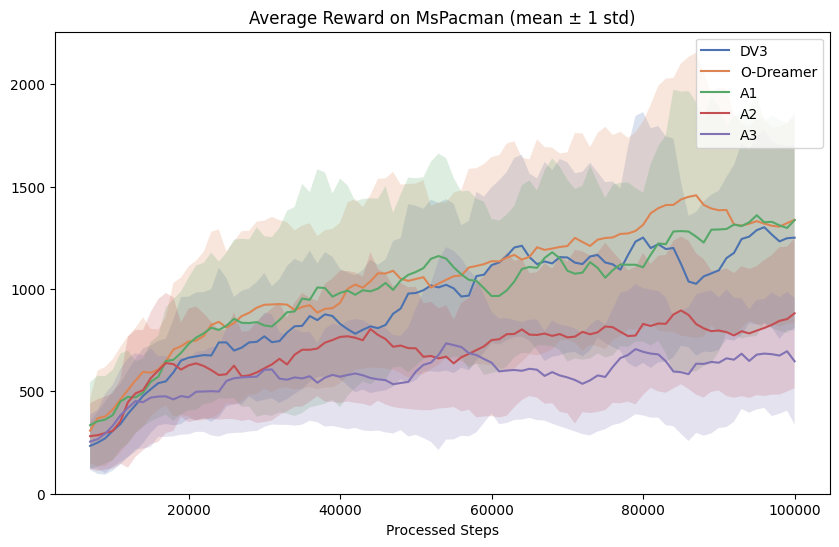

Plotting for metric: Game/ep_len_avg
AE_Keys
A1            8
A2            8
A3            8
DV3           8
O-Dreamer    11
Name: Run_ID, dtype: int64
Plotting for metric: Time/sps_env_interaction
AE_Keys
A1            8
A2            8
A3            8
DV3           8
O-Dreamer    11
Name: Run_ID, dtype: int64
Plotting for metric: Loss/world_model_loss
AE_Keys
A1            8
A2            8
A3            8
DV3           8
O-Dreamer    11
Name: Run_ID, dtype: int64
Plotting for metric: Loss/value_loss
AE_Keys
A1            8
A2            8
A3            8
DV3           8
O-Dreamer    11
Name: Run_ID, dtype: int64
Plotting for metric: Loss/policy_loss
AE_Keys
A1            8
A2            8
A3            8
DV3           8
O-Dreamer    11
Name: Run_ID, dtype: int64
Plotting for metric: Loss/observation_loss
AE_Keys
A1            8
A2            8
A3            8
DV3           8
O-Dreamer    11
Name: Run_ID, dtype: int64
Plotting for metric: Loss/reward_loss
AE_Keys
A1            8
A2  

/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

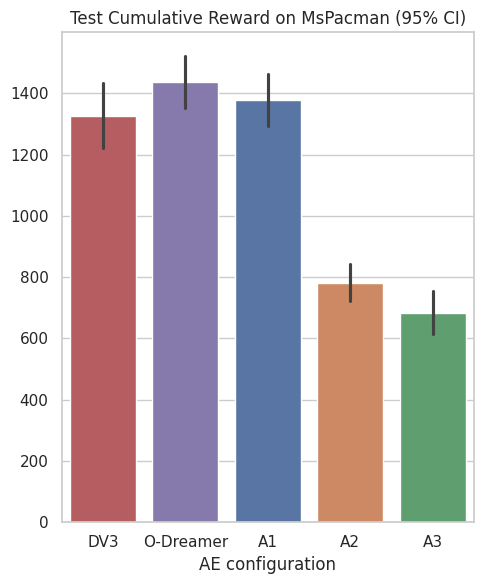

Plotting for metric: Loss/observation_loss_rgb
AE_Keys
A1            8
DV3           8
O-Dreamer    11
Name: Run_ID, dtype: int64
Plotting for metric: Train/cumulative_reward
AE_Keys
A1           3
A2           3
A3           3
DV3          3
O-Dreamer    3
Name: Run_ID, dtype: int64
Processing Assault...
Total number of experiments processed: 48
Unique train_every: [2 8]
Plotting for train_every: 2
Plotting for metric: Rewards/rew_avg
AE_Keys
A1           5
A2           5
A3           4
DV3          5
O-Dreamer    5
Name: Run_ID, dtype: int64


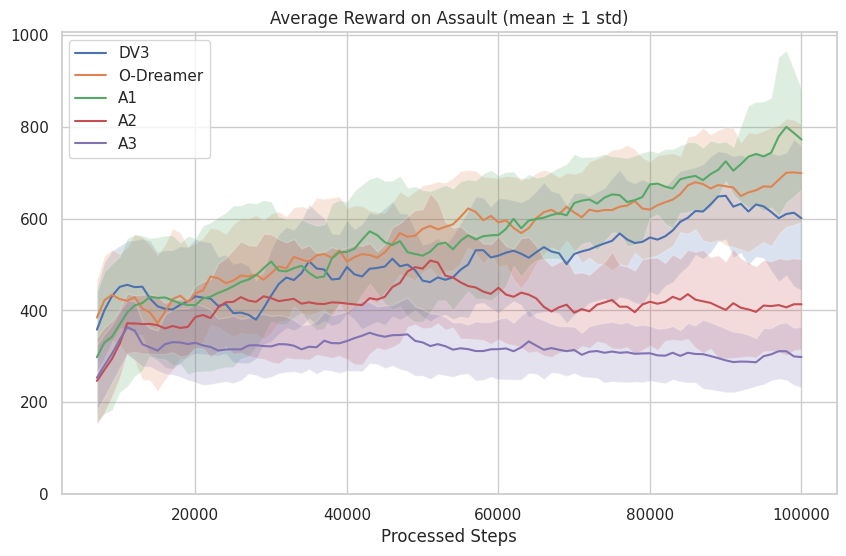

Plotting for metric: Game/ep_len_avg
AE_Keys
A1           5
A2           5
A3           4
DV3          5
O-Dreamer    5
Name: Run_ID, dtype: int64
Plotting for metric: Time/sps_env_interaction
AE_Keys
A1           5
A2           5
A3           4
DV3          5
O-Dreamer    5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/world_model_loss
AE_Keys
A1           5
A2           5
A3           4
DV3          5
O-Dreamer    5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/value_loss
AE_Keys
A1           5
A2           5
A3           4
DV3          5
O-Dreamer    5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/policy_loss
AE_Keys
A1           5
A2           5
A3           4
DV3          5
O-Dreamer    5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/observation_loss
AE_Keys
A1           5
A2           5
A3           4
DV3          5
O-Dreamer    5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/reward_loss
AE_Keys
A1           5
A2           5
A3           4
DV3  

/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

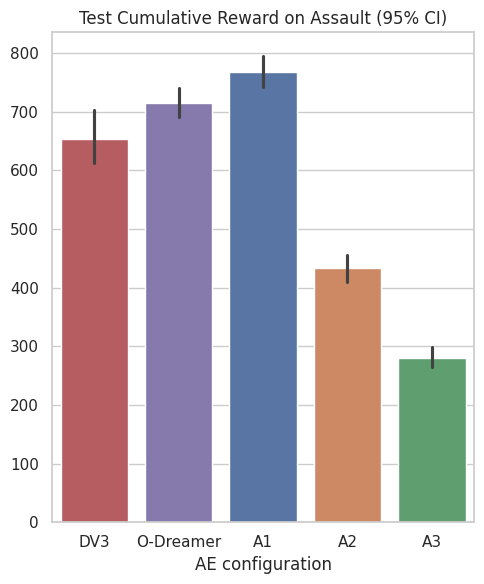

Processing Carnival...
Total number of experiments processed: 37
Unique train_every: [8 2]
Plotting for train_every: 2
Plotting for metric: Rewards/rew_avg
AE_Keys
A1           5
A2           5
A3           5
DV3          5
O-Dreamer    5
Name: Run_ID, dtype: int64


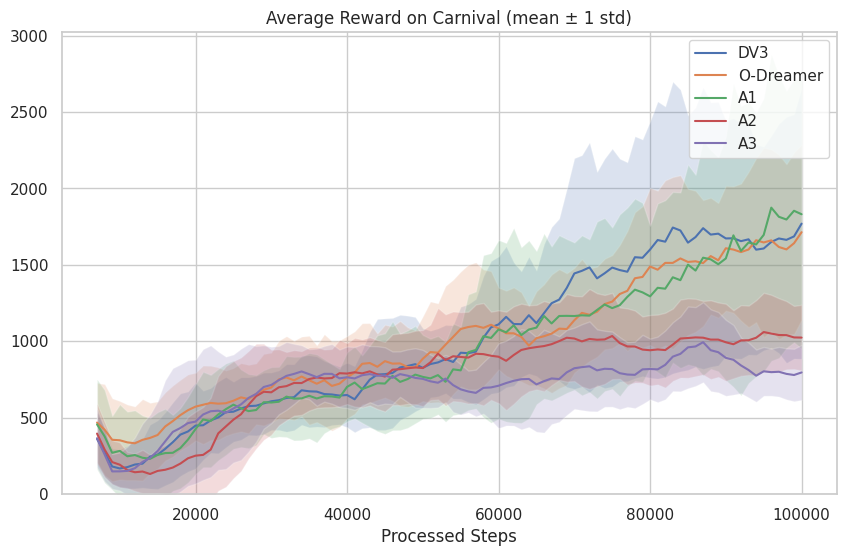

Plotting for metric: Game/ep_len_avg
AE_Keys
A1           5
A2           5
A3           5
DV3          5
O-Dreamer    5
Name: Run_ID, dtype: int64
Plotting for metric: Time/sps_env_interaction
AE_Keys
A1           5
A2           5
A3           5
DV3          5
O-Dreamer    5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/world_model_loss
AE_Keys
A1           5
A2           5
A3           5
DV3          5
O-Dreamer    5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/value_loss
AE_Keys
A1           5
A2           5
A3           5
DV3          5
O-Dreamer    5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/policy_loss
AE_Keys
A1           5
A2           5
A3           5
DV3          5
O-Dreamer    5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/observation_loss
AE_Keys
A1           5
A2           5
A3           5
DV3          5
O-Dreamer    5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/reward_loss
AE_Keys
A1           5
A2           5
A3           5
DV3  

/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

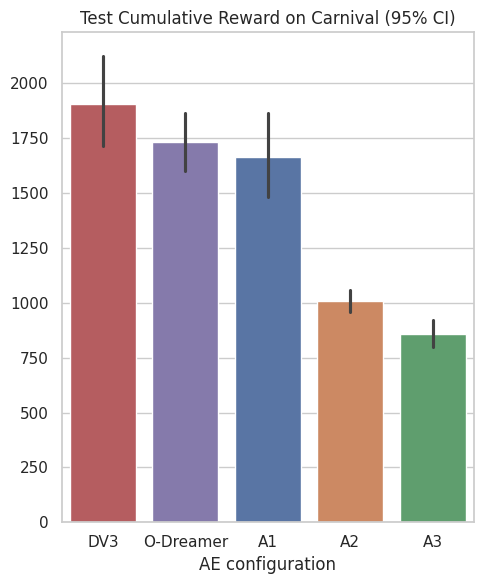

In [7]:
games = ['MsPacman', 'Assault', 'Carnival']
#games = ['Assault']

for game in games:
    print(f"Processing {game}...")
    game_path = f'logs/runs/dreamer_v3/{game}NoFrameskip-v4'
    update_viz(game_path)

# Perturbations

Total number of experiments processed: 48
Plotting for metric: Rewards/rew_avg
Perturbation
All               3
False positive    3
Noise             3
None              5
Occlusion         3
Name: Run_ID, dtype: int64


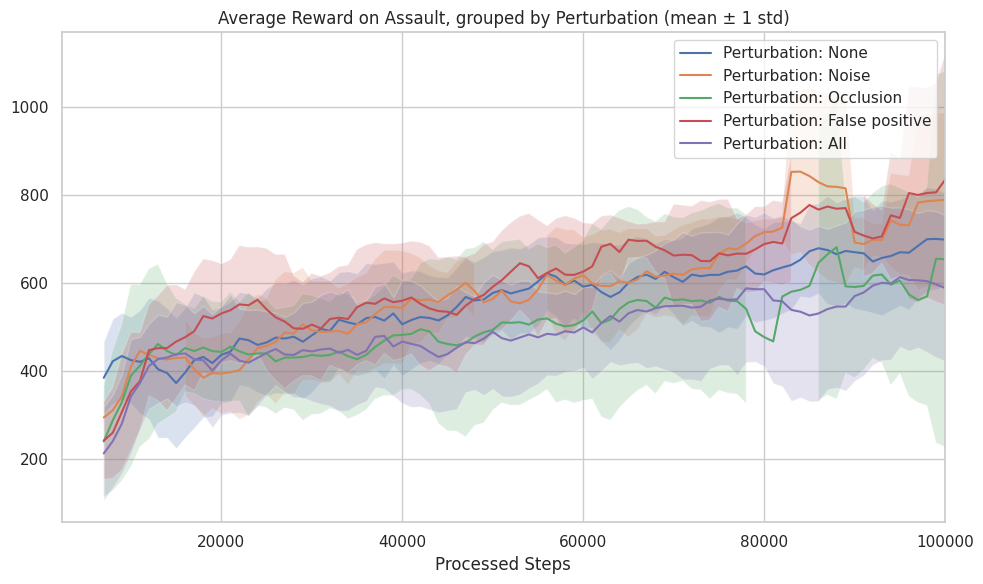

Plotting for metric: Game/ep_len_avg
Perturbation
All               3
False positive    3
Noise             3
None              5
Occlusion         3
Name: Run_ID, dtype: int64


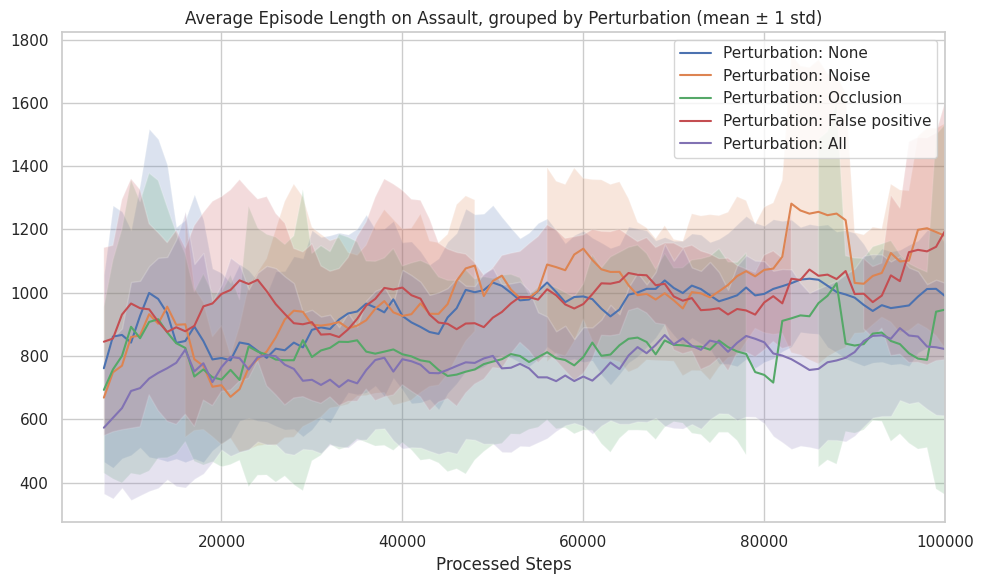

Plotting for metric: Time/sps_env_interaction
Perturbation
All               3
False positive    3
Noise             3
None              5
Occlusion         3
Name: Run_ID, dtype: int64


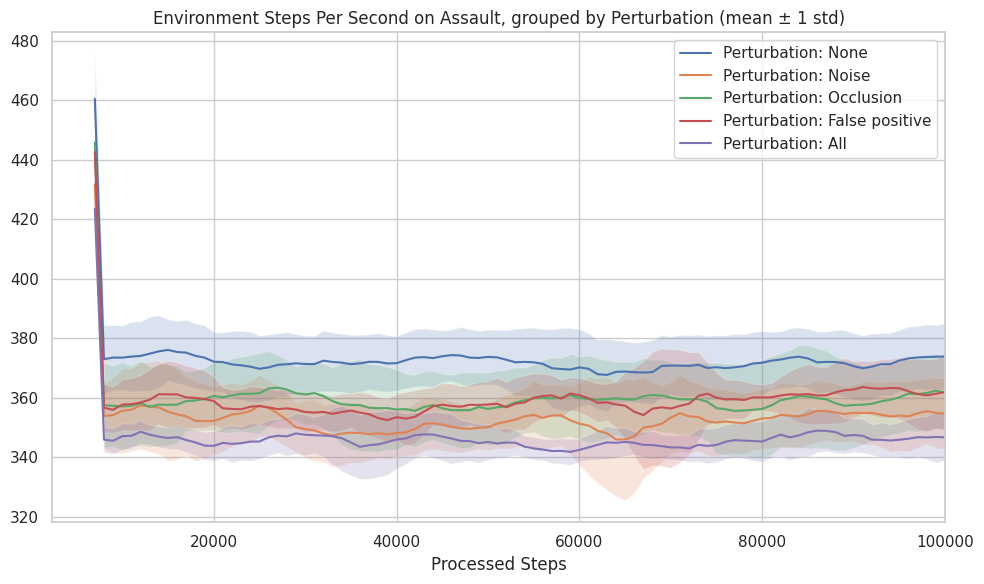

Plotting for metric: Loss/world_model_loss
Perturbation
All               3
False positive    3
Noise             3
None              5
Occlusion         3
Name: Run_ID, dtype: int64


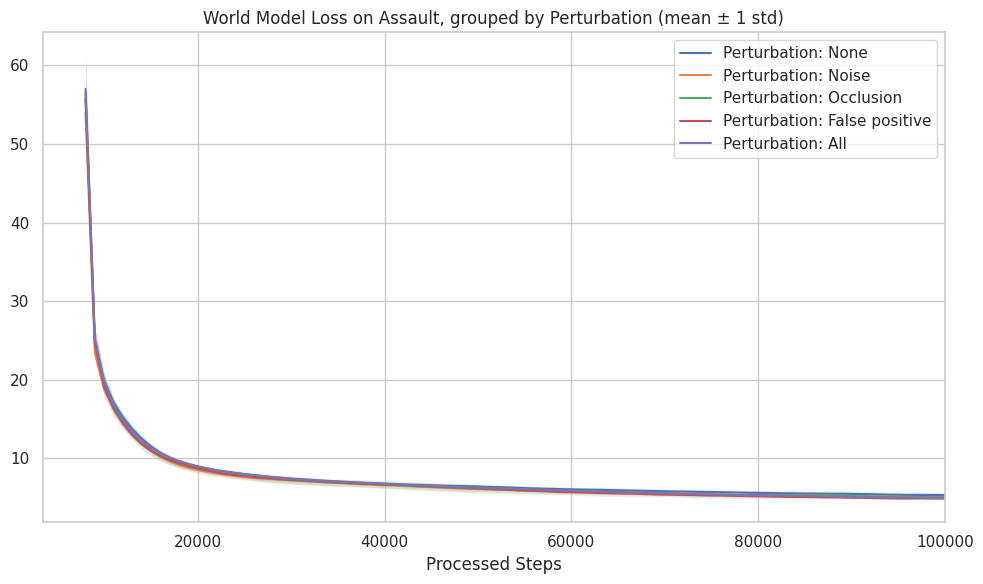

Plotting for metric: Loss/value_loss
Perturbation
All               3
False positive    3
Noise             3
None              5
Occlusion         3
Name: Run_ID, dtype: int64


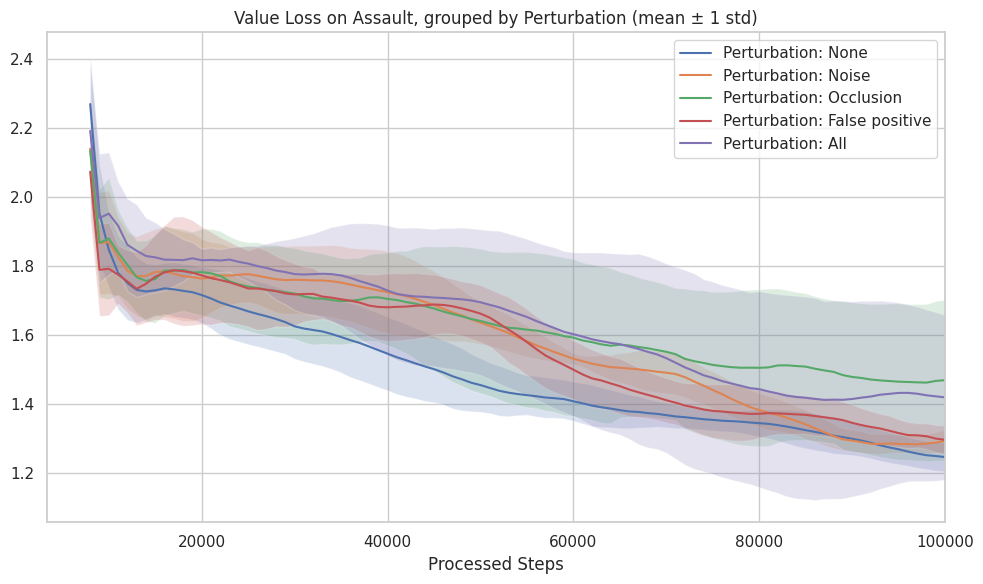

Plotting for metric: Loss/policy_loss
Perturbation
All               3
False positive    3
Noise             3
None              5
Occlusion         3
Name: Run_ID, dtype: int64


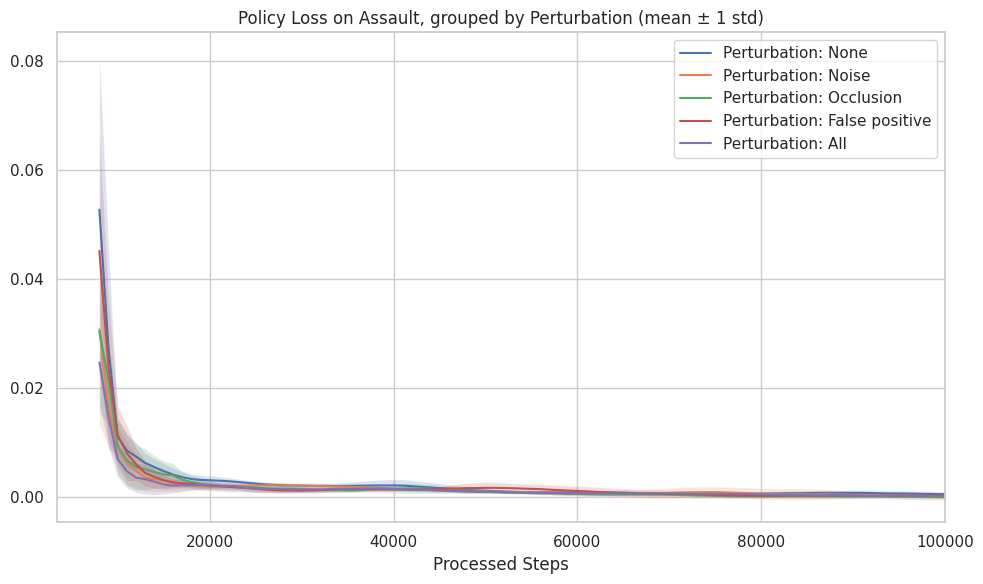

Plotting for metric: Loss/observation_loss
Perturbation
All               3
False positive    3
Noise             3
None              5
Occlusion         3
Name: Run_ID, dtype: int64


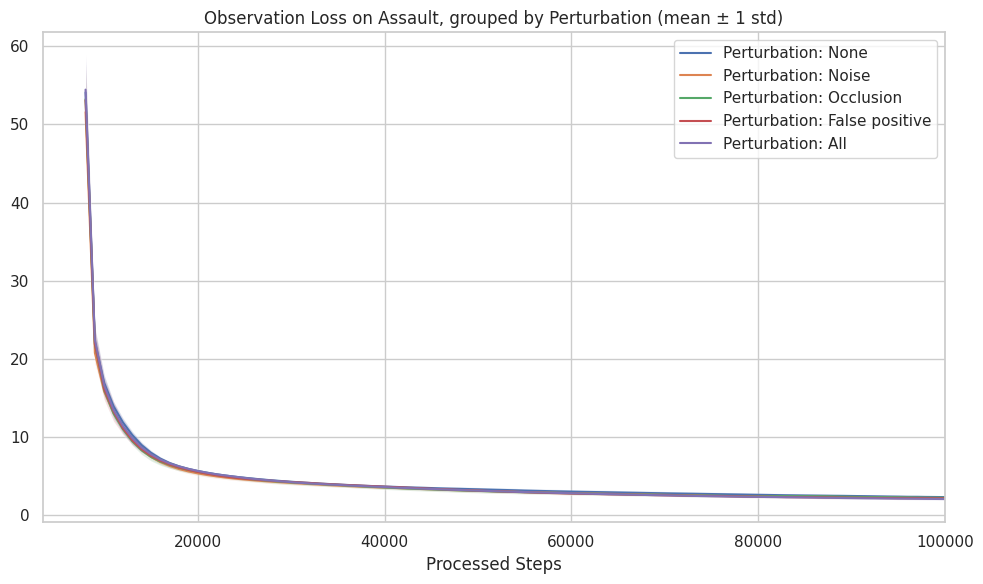

Plotting for metric: Loss/reward_loss
Perturbation
All               3
False positive    3
Noise             3
None              5
Occlusion         3
Name: Run_ID, dtype: int64


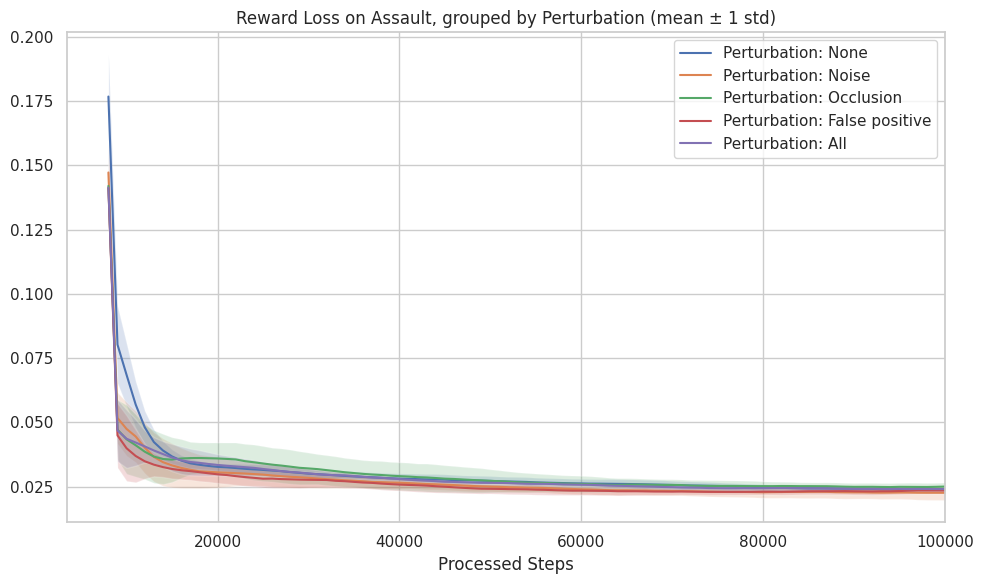

Plotting for metric: Loss/state_loss
Perturbation
All               3
False positive    3
Noise             3
None              5
Occlusion         3
Name: Run_ID, dtype: int64


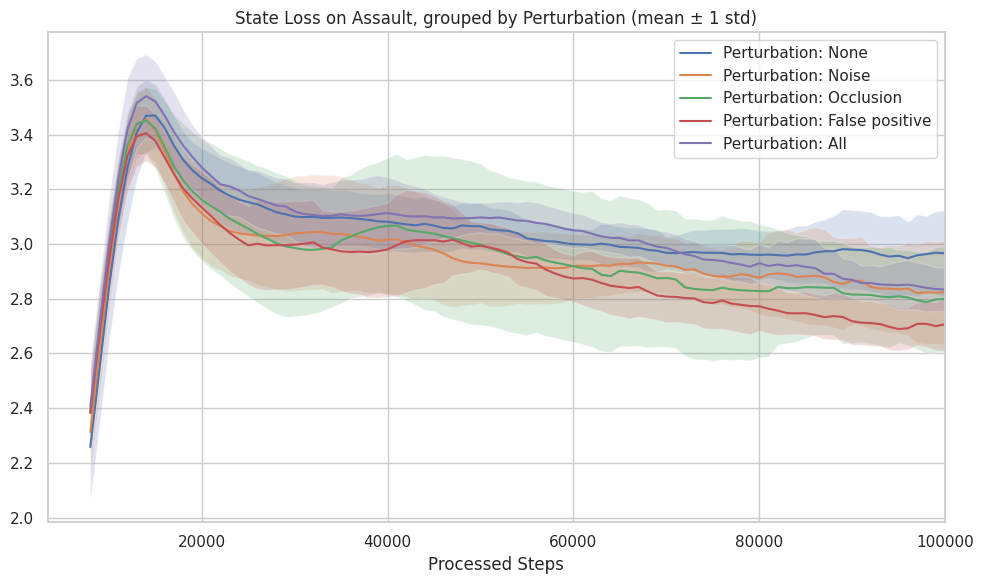

Plotting for metric: Loss/continue_loss
Perturbation
All               3
False positive    3
Noise             3
None              5
Occlusion         3
Name: Run_ID, dtype: int64


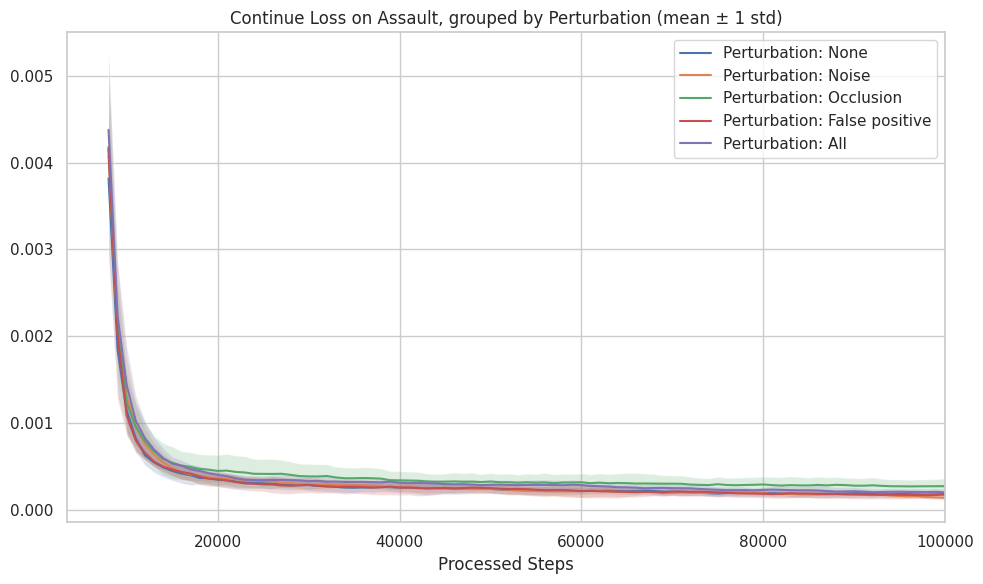

Plotting for metric: State/kl
Perturbation
All               3
False positive    3
Noise             3
None              5
Occlusion         3
Name: Run_ID, dtype: int64


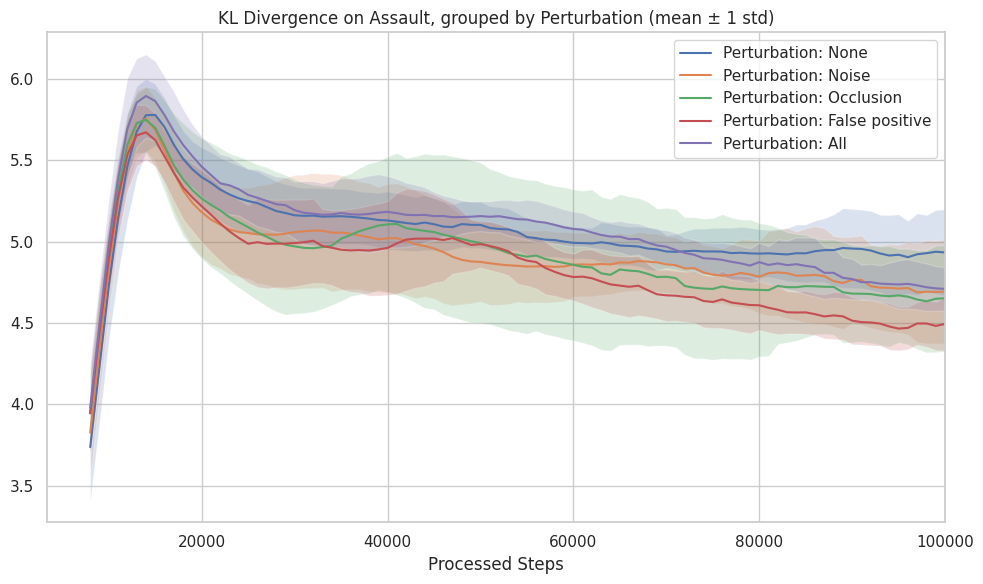

Plotting for metric: State/post_entropy
Perturbation
All               3
False positive    3
Noise             3
None              5
Occlusion         3
Name: Run_ID, dtype: int64


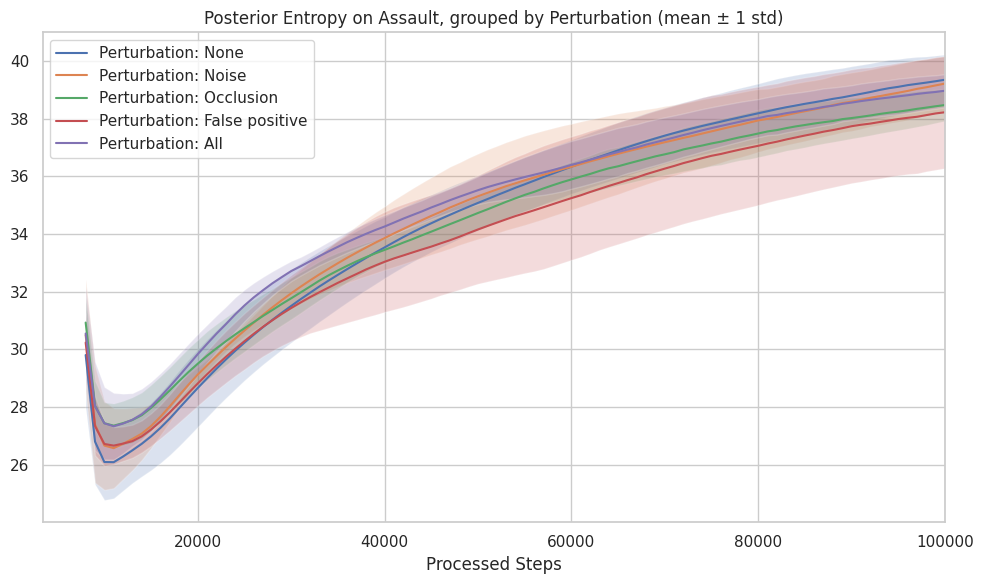

Plotting for metric: State/prior_entropy
Perturbation
All               3
False positive    3
Noise             3
None              5
Occlusion         3
Name: Run_ID, dtype: int64


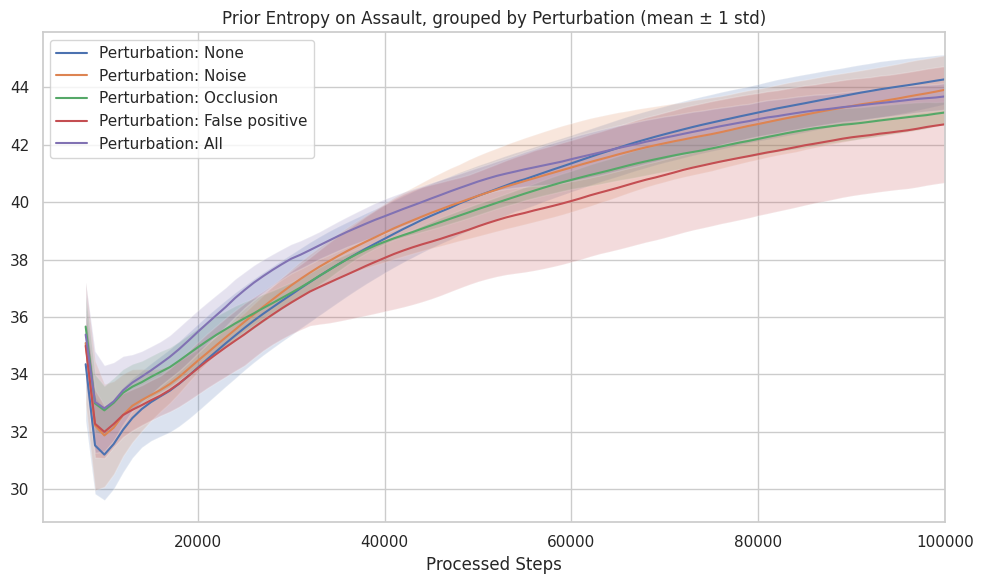

Plotting for metric: Grads/world_model
Perturbation
All               3
False positive    3
Noise             3
None              5
Occlusion         3
Name: Run_ID, dtype: int64


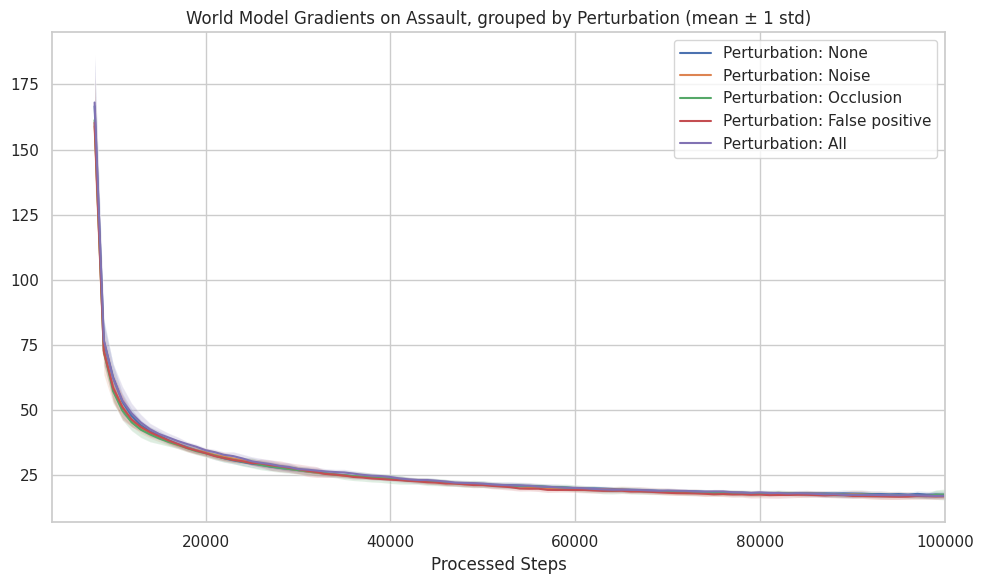

Plotting for metric: Grads/actor
Perturbation
All               3
False positive    3
Noise             3
None              5
Occlusion         3
Name: Run_ID, dtype: int64


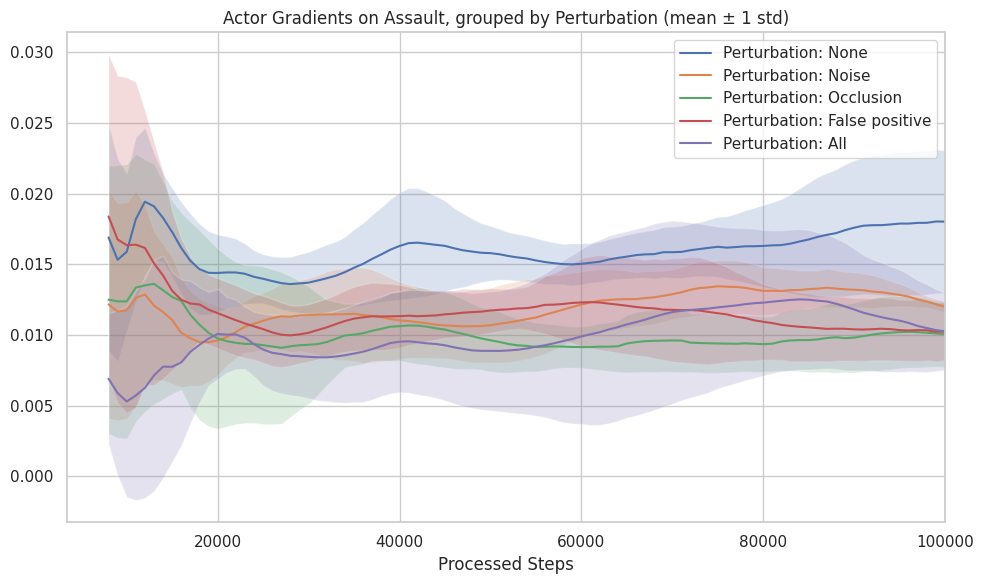

Plotting for metric: Grads/critic
Perturbation
All               3
False positive    3
Noise             3
None              5
Occlusion         3
Name: Run_ID, dtype: int64


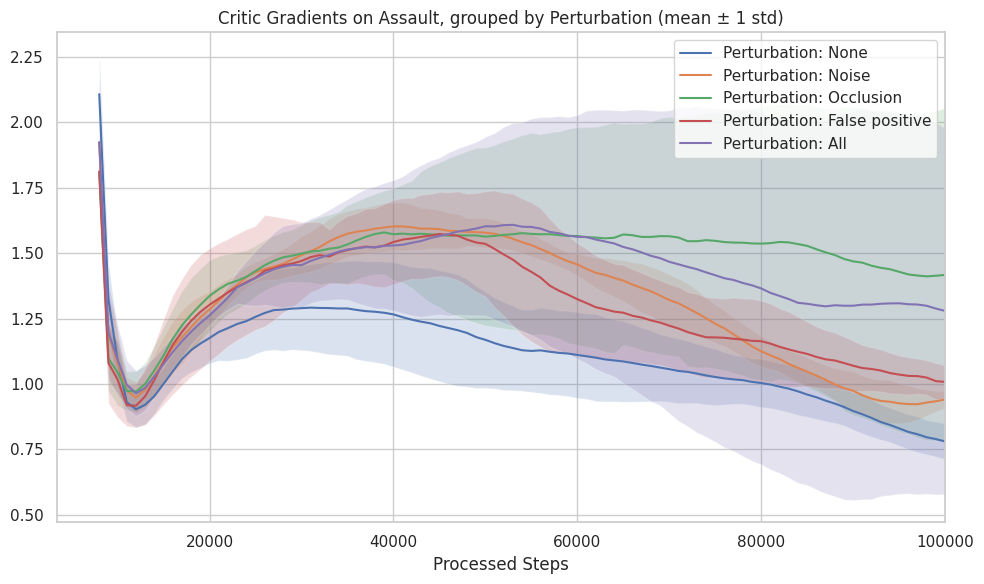

Plotting for metric: Loss/observation_loss_rgb
Perturbation
All               3
False positive    3
Noise             3
None              5
Occlusion         3
Name: Run_ID, dtype: int64


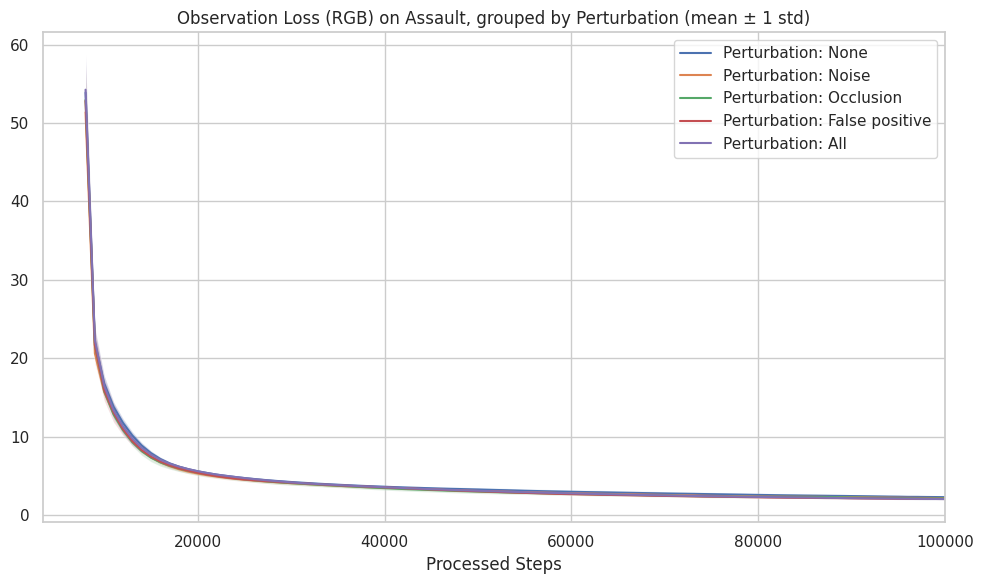

Plotting for metric: Loss/observation_loss_objects_position
Perturbation
All               3
False positive    3
Noise             3
None              5
Occlusion         3
Name: Run_ID, dtype: int64


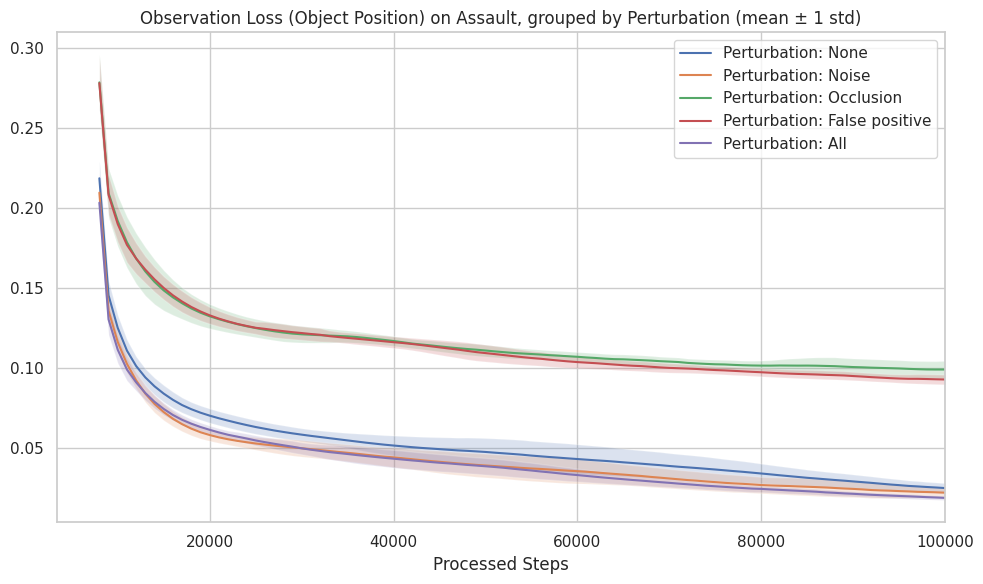

Plotting for metric: Time/sps_train
Perturbation
All               3
False positive    3
Noise             3
None              5
Occlusion         3
Name: Run_ID, dtype: int64


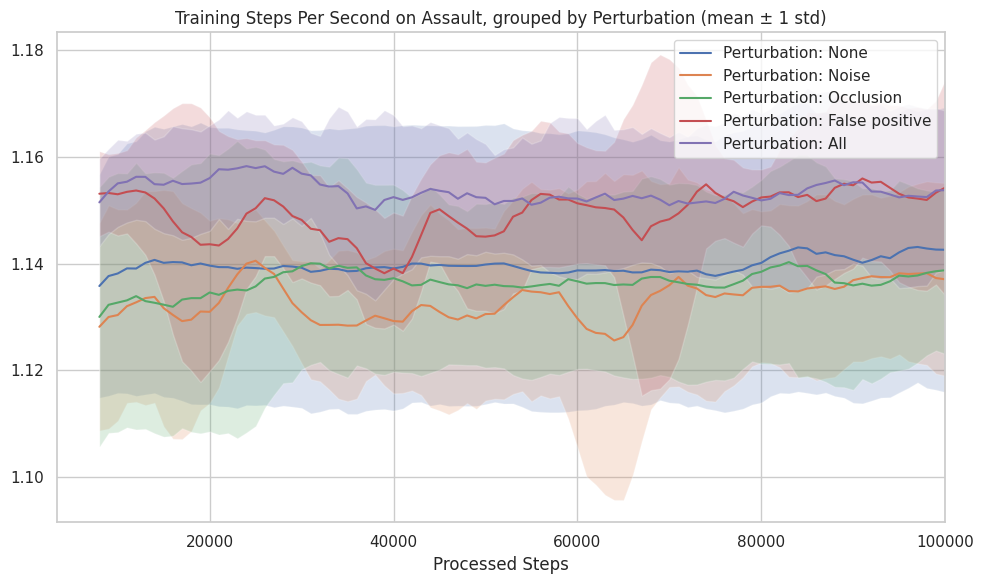

/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

Plotting for metric: Test/cumulative_reward
Perturbation
All                60
False positive     60
Noise              59
None              100
Occlusion          60
Name: Value, dtype: int64


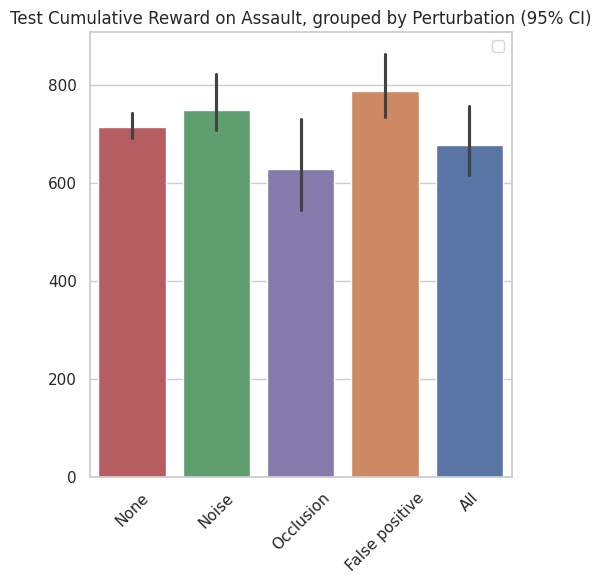

In [13]:
perturbation_orderd = ["None", "Noise", "Occlusion", "False positive", "All"]
analyze_and_plot_by_parameter('Assault', 'Perturbation', order=perturbation_orderd)

# Object loss scaling

Total number of experiments processed: 79
Plotting for metric: Rewards/rew_avg
Obs_Loss_Regularizer
1.0      11
10.0      3
100.0     3
300.0     3
Name: Run_ID, dtype: int64


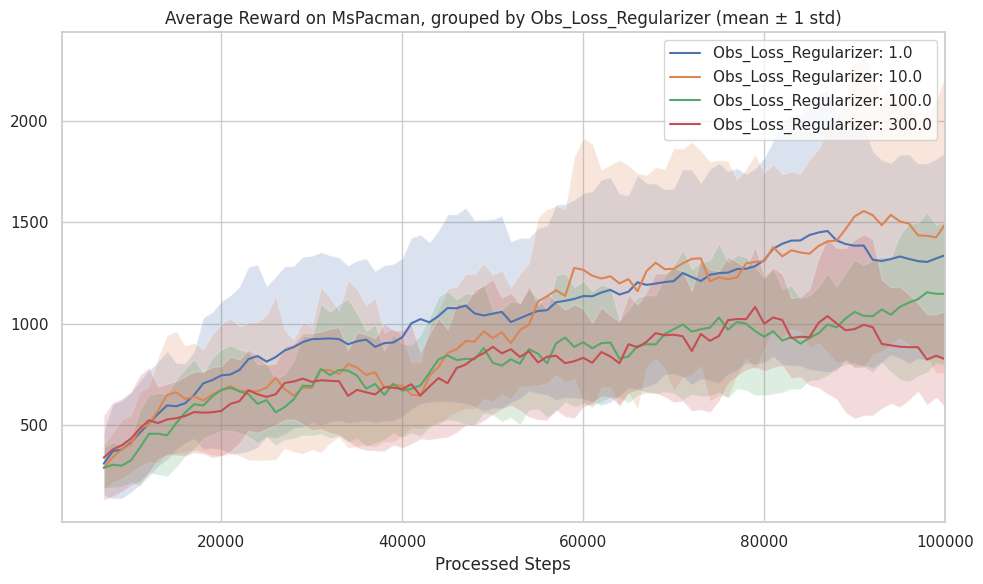

Plotting for metric: Game/ep_len_avg
Obs_Loss_Regularizer
1.0      11
10.0      3
100.0     3
300.0     3
Name: Run_ID, dtype: int64


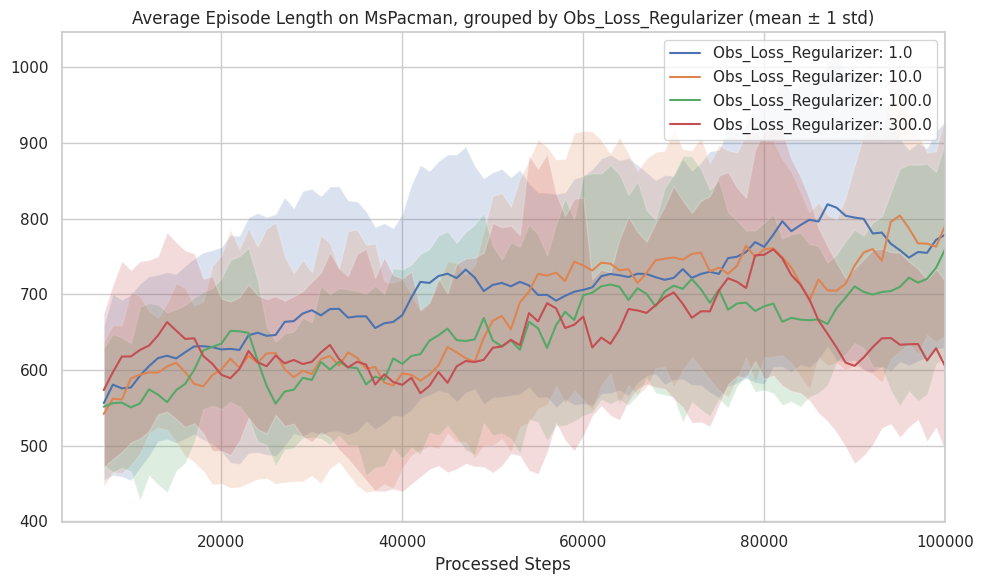

Plotting for metric: Time/sps_env_interaction
Obs_Loss_Regularizer
1.0      11
10.0      3
100.0     3
300.0     3
Name: Run_ID, dtype: int64


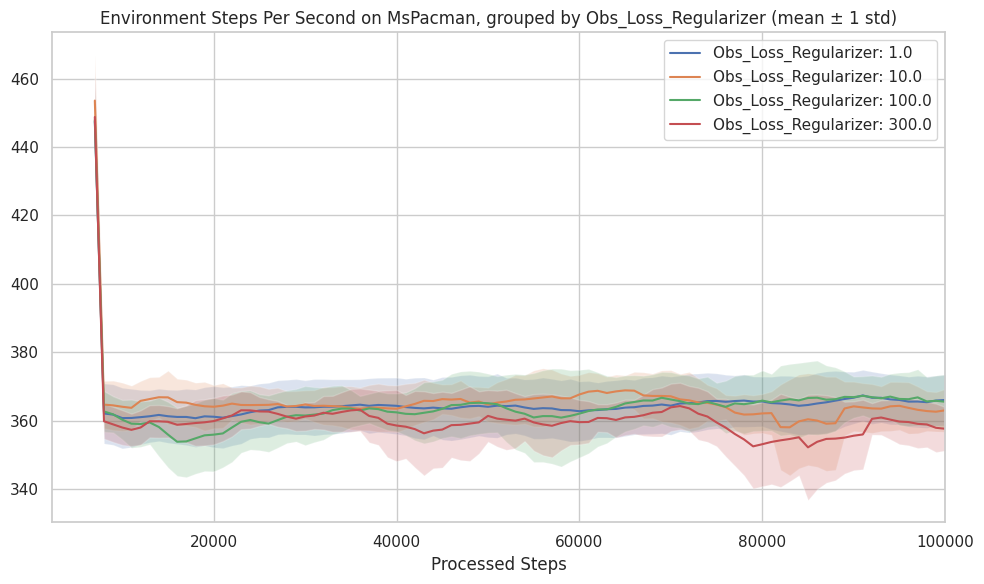

Plotting for metric: Loss/world_model_loss
Obs_Loss_Regularizer
1.0      11
10.0      3
100.0     3
300.0     3
Name: Run_ID, dtype: int64


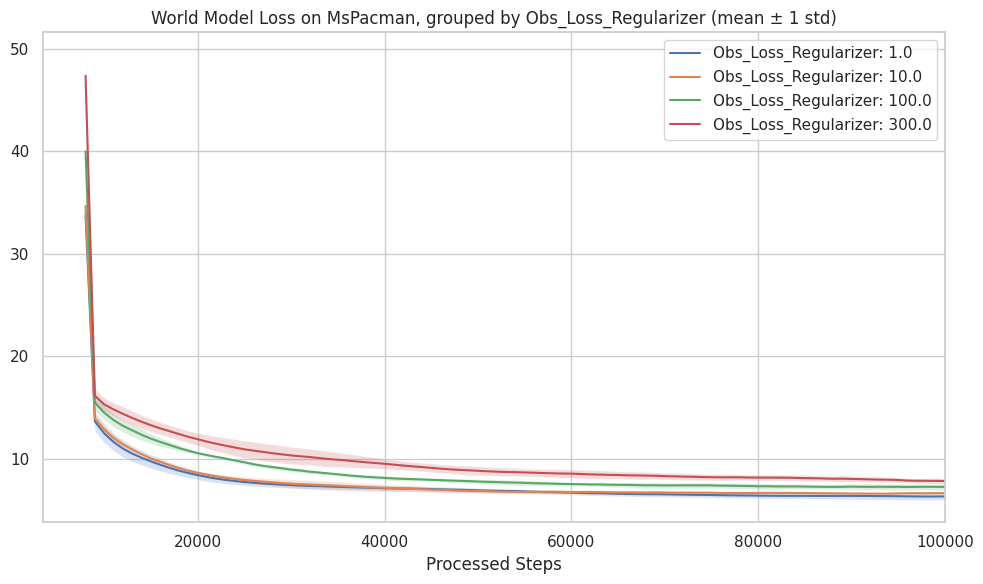

Plotting for metric: Loss/value_loss
Obs_Loss_Regularizer
1.0      11
10.0      3
100.0     3
300.0     3
Name: Run_ID, dtype: int64


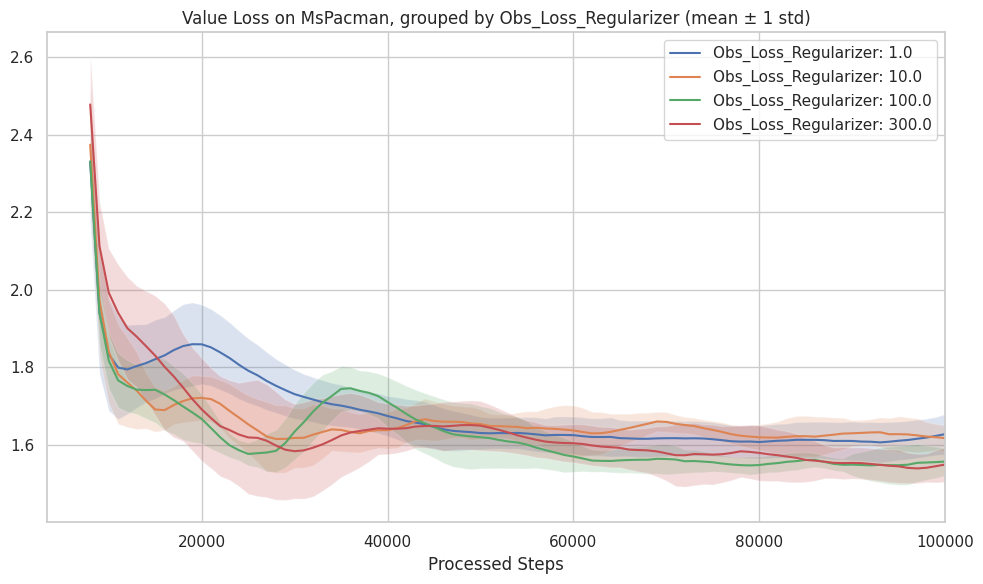

Plotting for metric: Loss/policy_loss
Obs_Loss_Regularizer
1.0      11
10.0      3
100.0     3
300.0     3
Name: Run_ID, dtype: int64


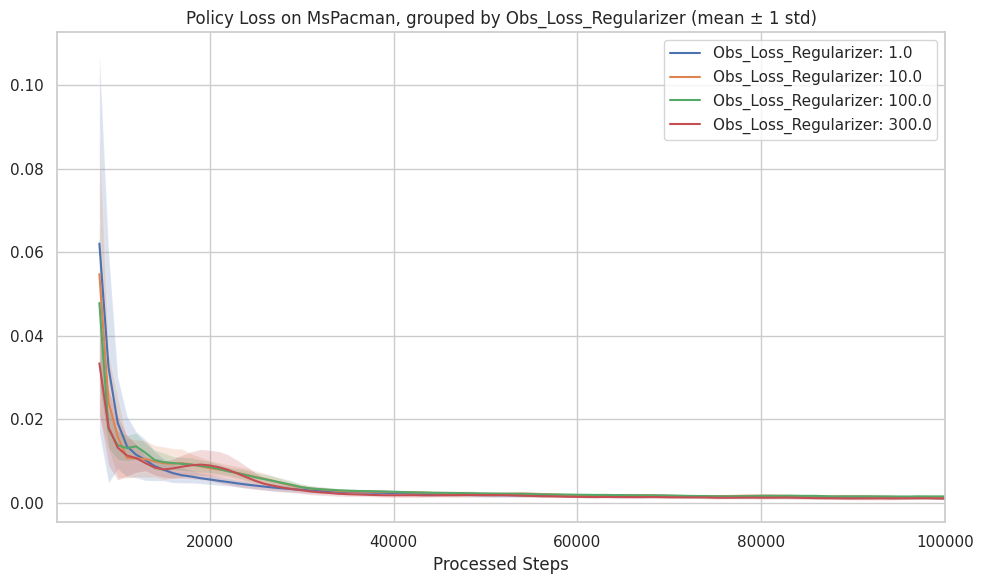

Plotting for metric: Loss/observation_loss
Obs_Loss_Regularizer
1.0      11
10.0      3
100.0     3
300.0     3
Name: Run_ID, dtype: int64


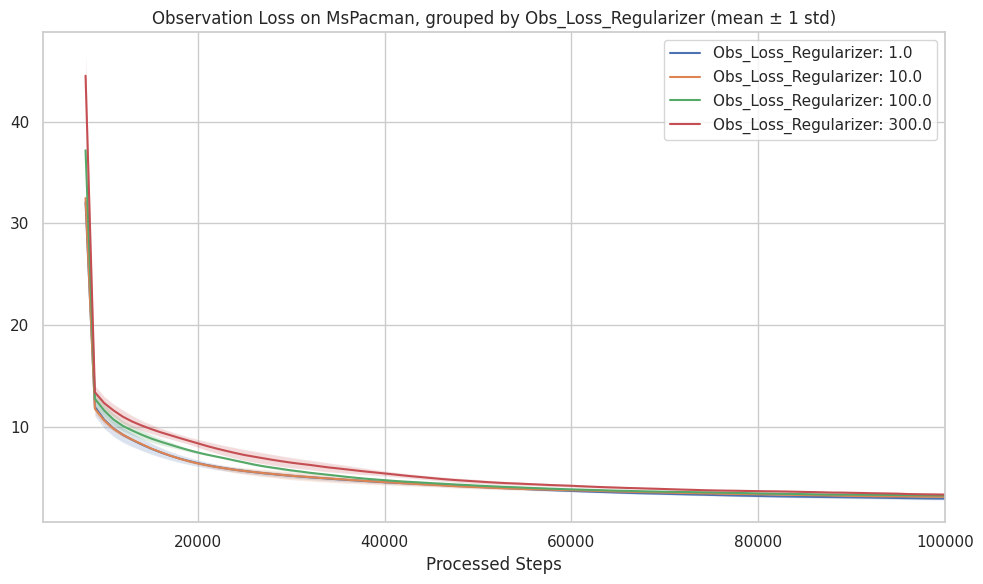

Plotting for metric: Loss/reward_loss
Obs_Loss_Regularizer
1.0      11
10.0      3
100.0     3
300.0     3
Name: Run_ID, dtype: int64


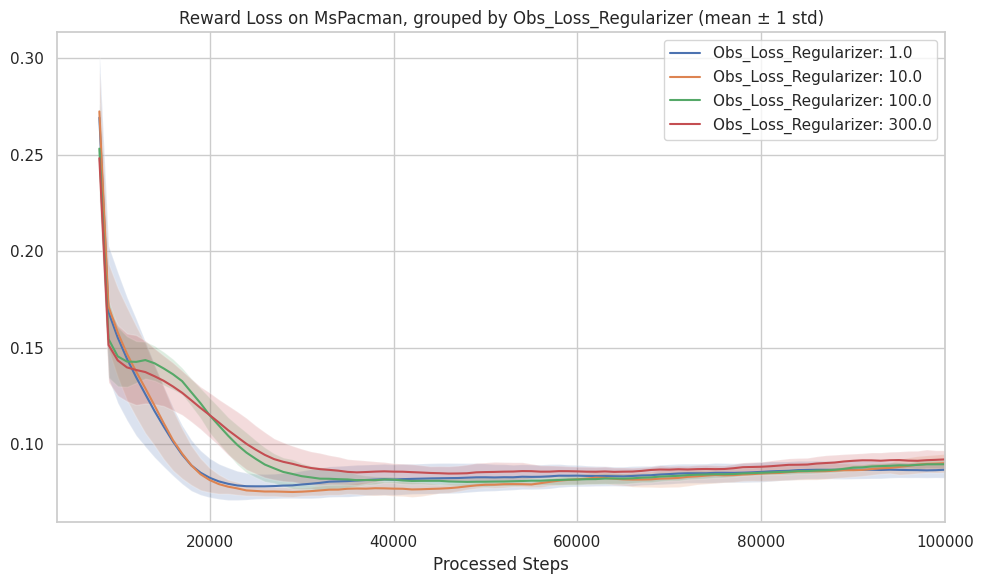

Plotting for metric: Loss/state_loss
Obs_Loss_Regularizer
1.0      11
10.0      3
100.0     3
300.0     3
Name: Run_ID, dtype: int64


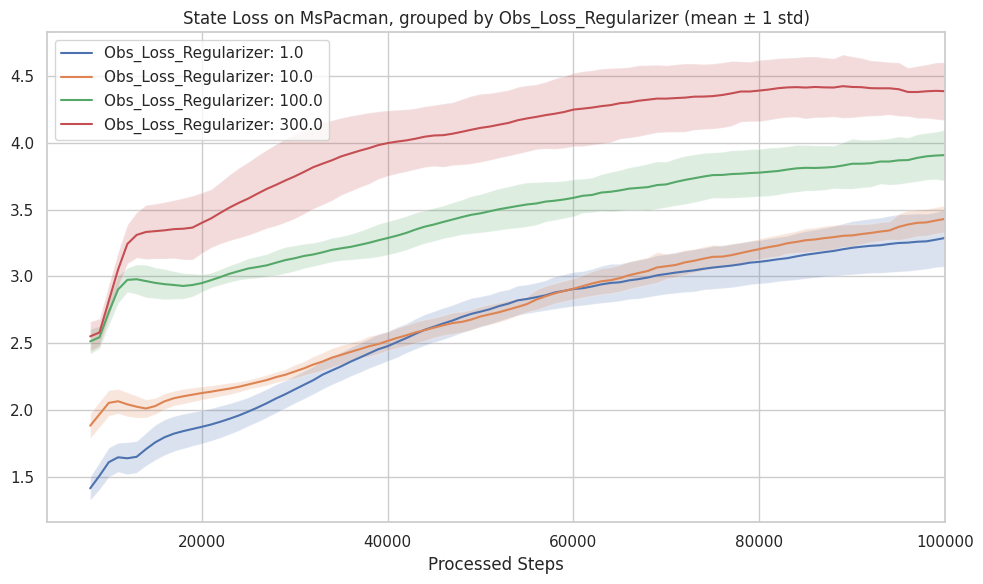

Plotting for metric: Loss/continue_loss
Obs_Loss_Regularizer
1.0      11
10.0      3
100.0     3
300.0     3
Name: Run_ID, dtype: int64


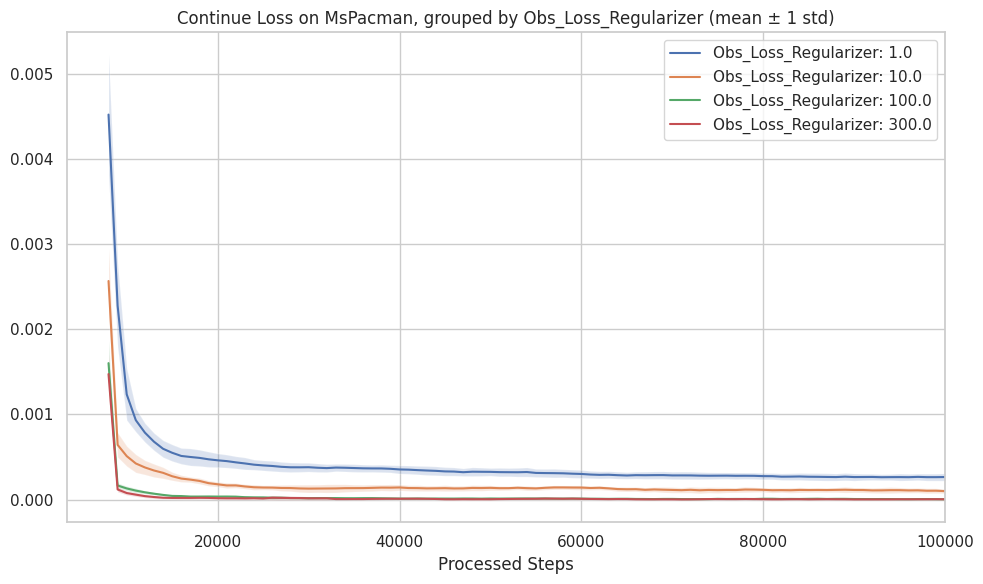

Plotting for metric: State/kl
Obs_Loss_Regularizer
1.0      11
10.0      3
100.0     3
300.0     3
Name: Run_ID, dtype: int64


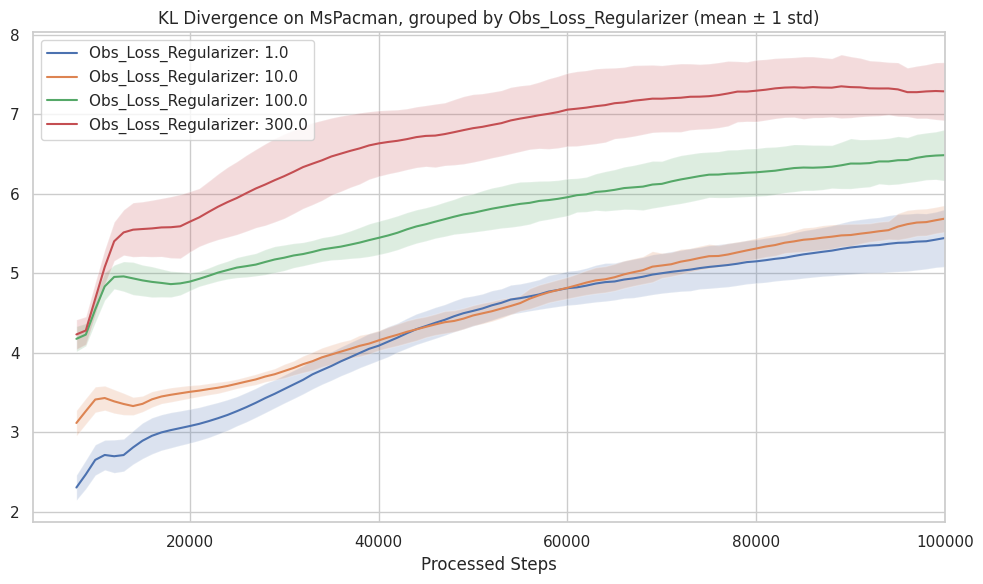

Plotting for metric: State/post_entropy
Obs_Loss_Regularizer
1.0      11
10.0      3
100.0     3
300.0     3
Name: Run_ID, dtype: int64


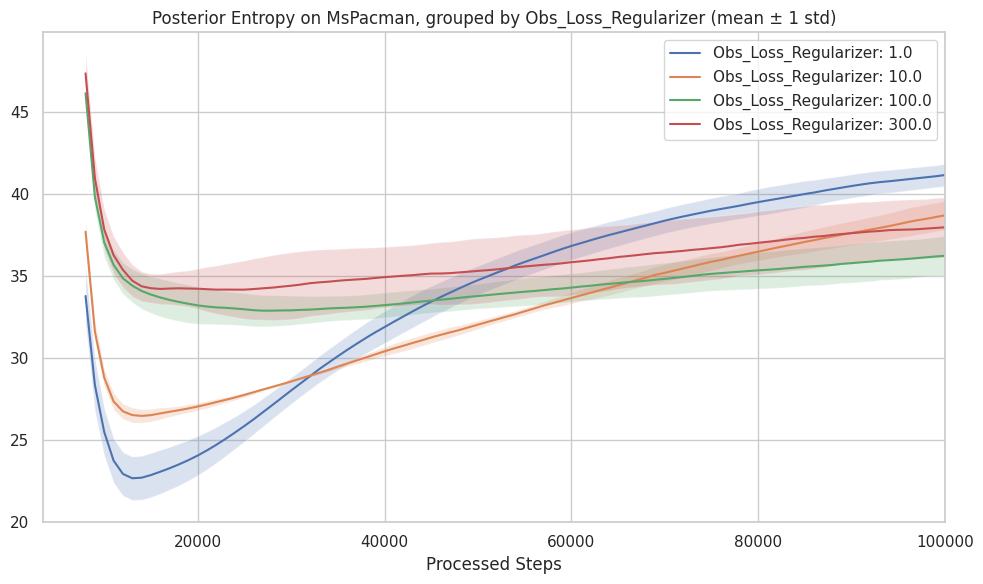

Plotting for metric: State/prior_entropy
Obs_Loss_Regularizer
1.0      11
10.0      3
100.0     3
300.0     3
Name: Run_ID, dtype: int64


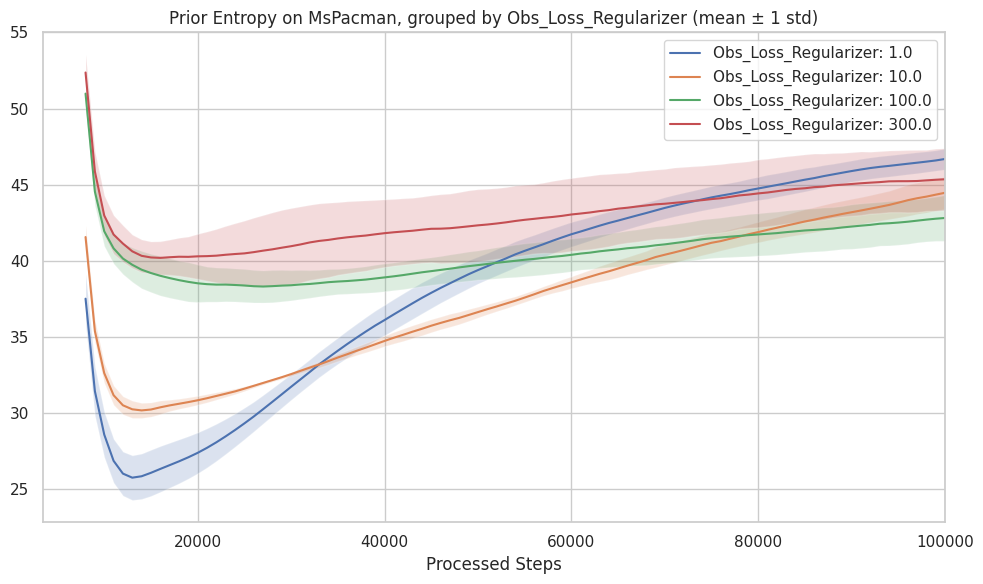

Plotting for metric: Grads/world_model
Obs_Loss_Regularizer
1.0      11
10.0      3
100.0     3
300.0     3
Name: Run_ID, dtype: int64


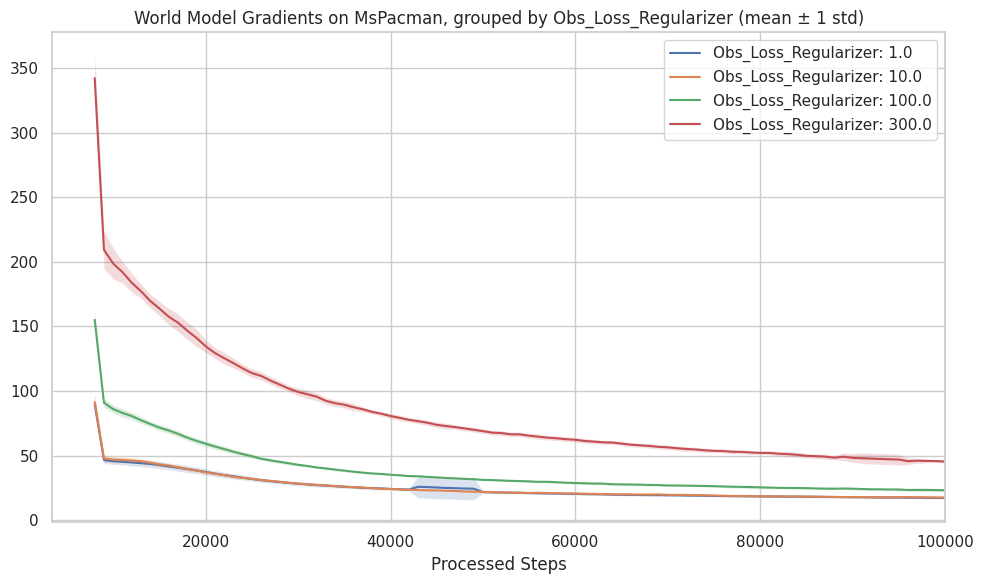

Plotting for metric: Grads/actor
Obs_Loss_Regularizer
1.0      11
10.0      3
100.0     3
300.0     3
Name: Run_ID, dtype: int64


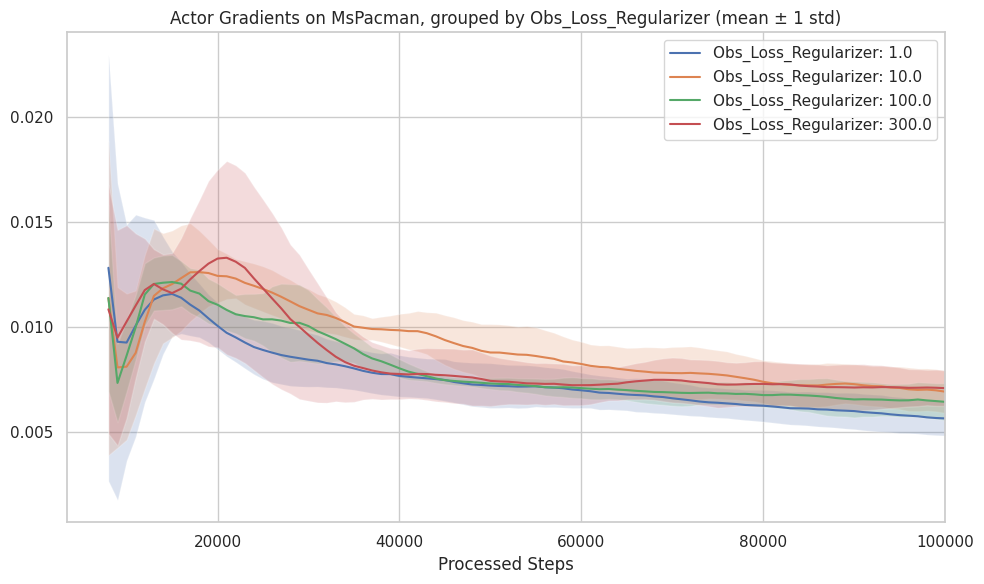

Plotting for metric: Grads/critic
Obs_Loss_Regularizer
1.0      11
10.0      3
100.0     3
300.0     3
Name: Run_ID, dtype: int64


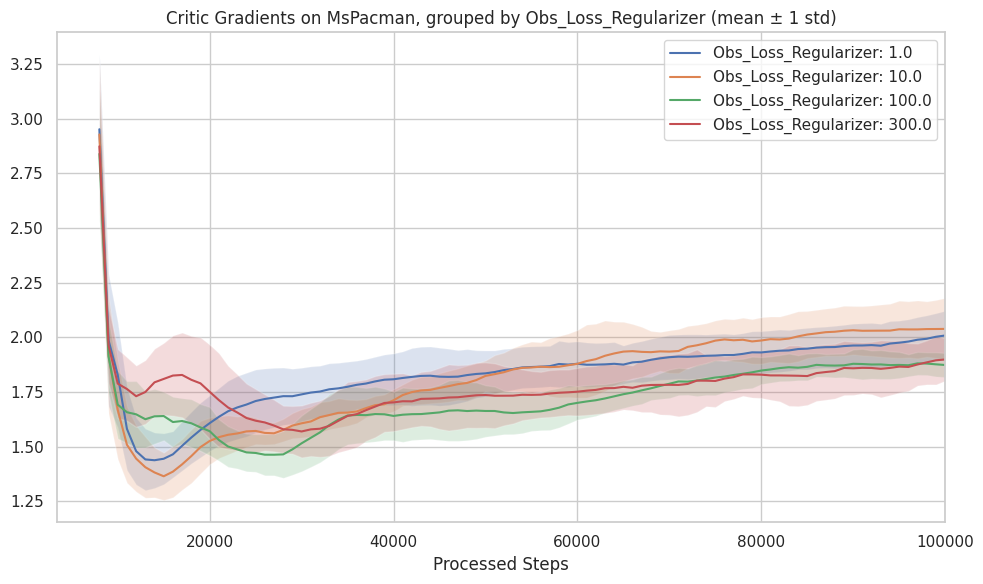

Plotting for metric: Loss/observation_loss_rgb
Obs_Loss_Regularizer
1.0      11
10.0      3
100.0     3
300.0     3
Name: Run_ID, dtype: int64


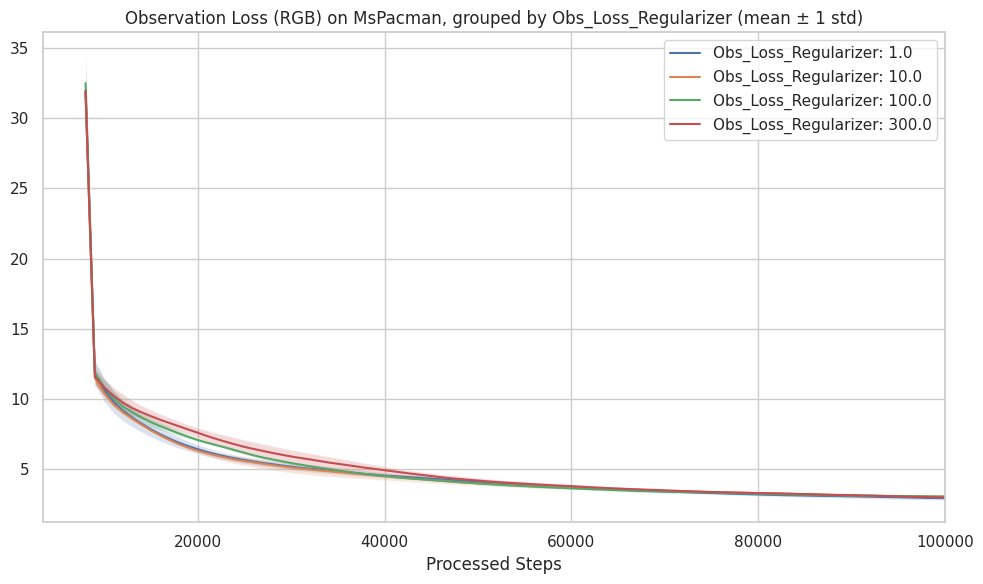

Plotting for metric: Loss/observation_loss_objects_position
Obs_Loss_Regularizer
1.0      11
10.0      3
100.0     3
300.0     3
Name: Run_ID, dtype: int64


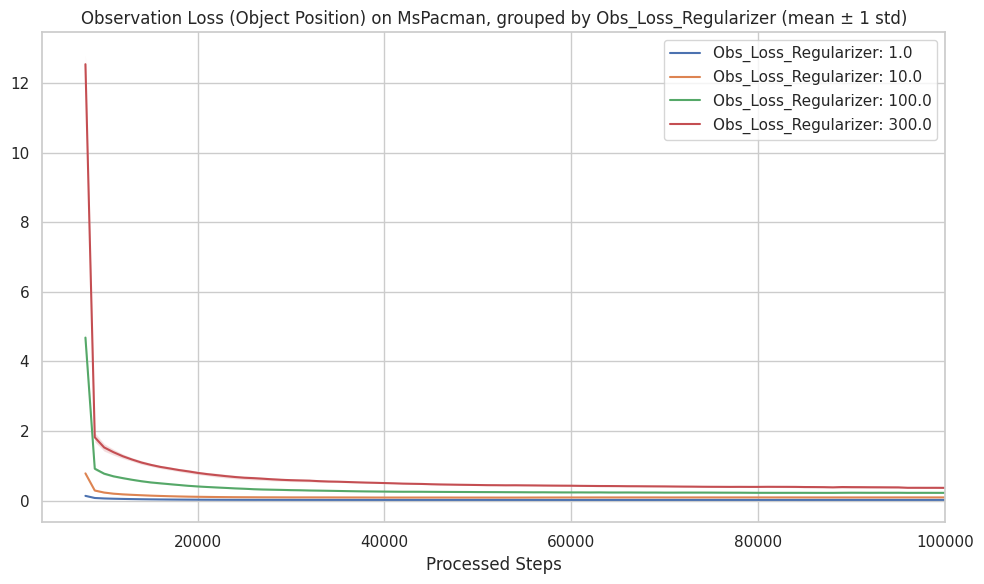

Plotting for metric: Time/sps_train
Obs_Loss_Regularizer
1.0      11
10.0      3
100.0     3
300.0     3
Name: Run_ID, dtype: int64


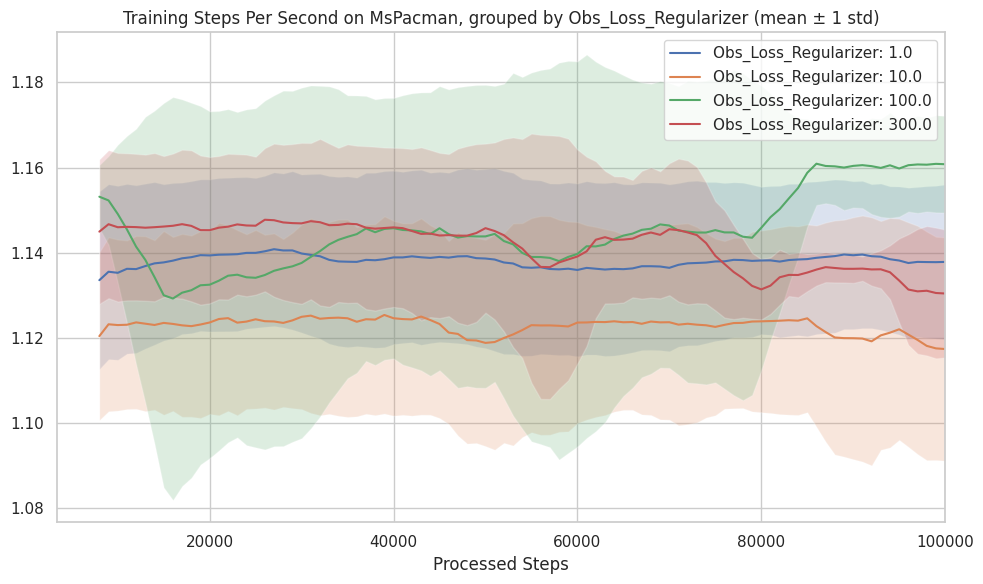

Plotting for metric: Test/cumulative_reward
Obs_Loss_Regularizer
1.0      220
10.0      60
100.0     60
300.0     60
Name: Value, dtype: int64


/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

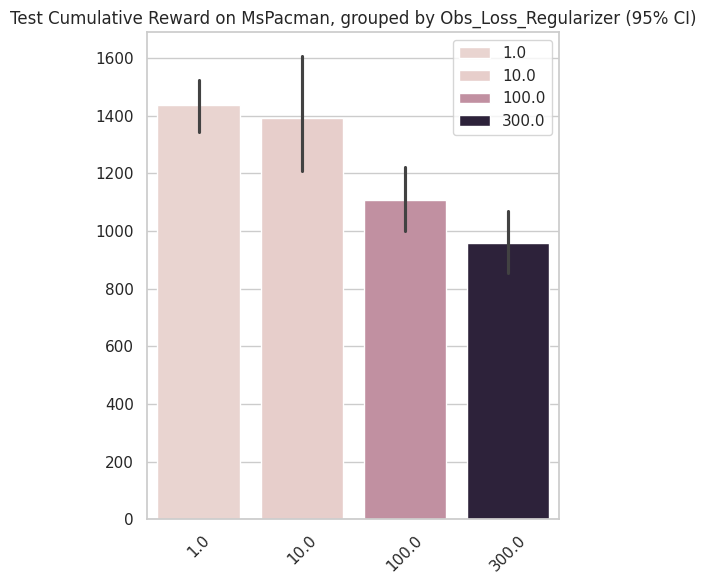

Plotting for metric: Train/cumulative_reward
Obs_Loss_Regularizer
1.0    3
Name: Run_ID, dtype: int64


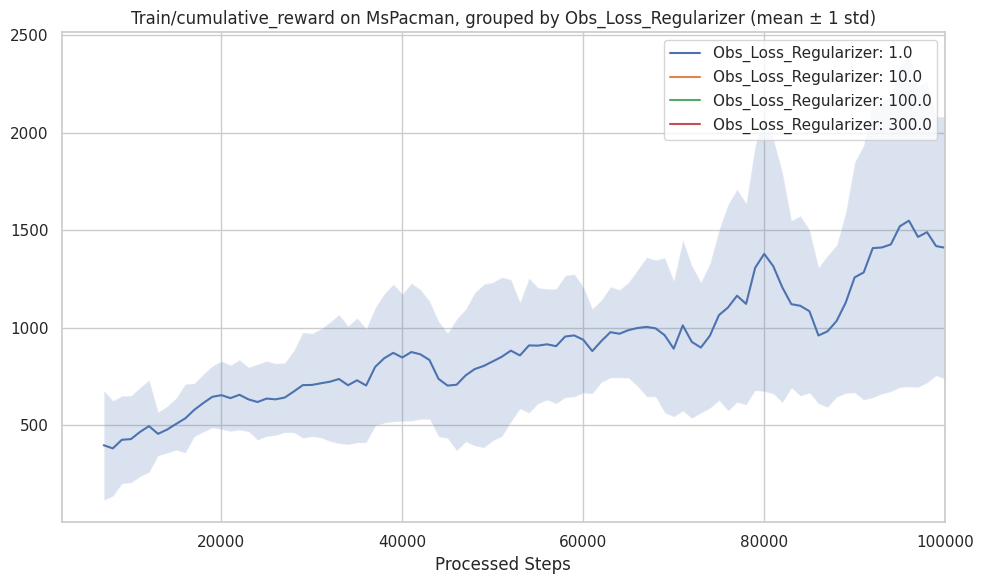

In [9]:
analyze_and_plot_by_parameter('MsPacman', 'Obs_Loss_Regularizer')

# Buffer 10K

Total number of experiments processed: 79
Plotting for metric: Rewards/rew_avg
Buffer_Size
10000      3
100000    11
Name: Run_ID, dtype: int64


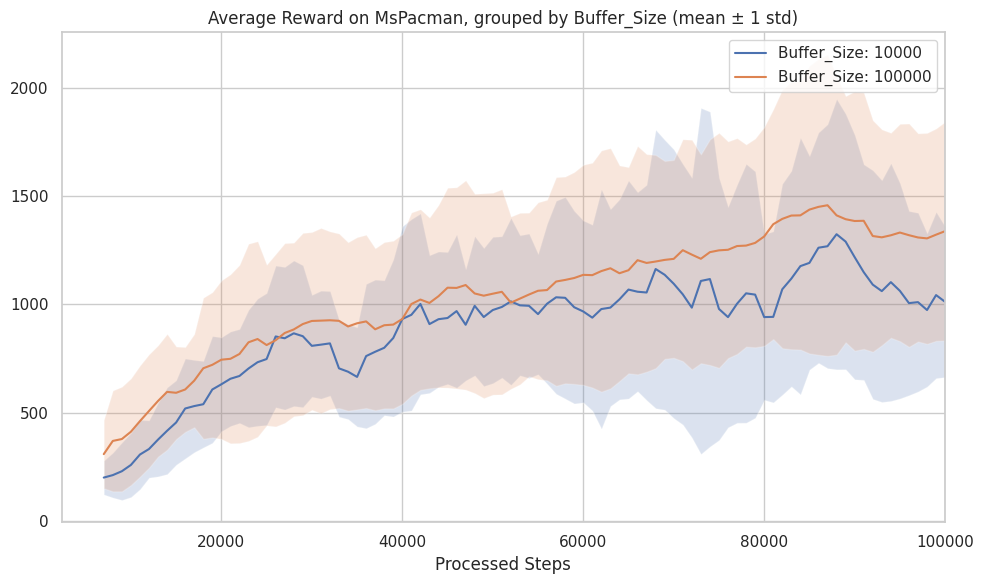

Plotting for metric: Game/ep_len_avg
Buffer_Size
10000      3
100000    11
Name: Run_ID, dtype: int64


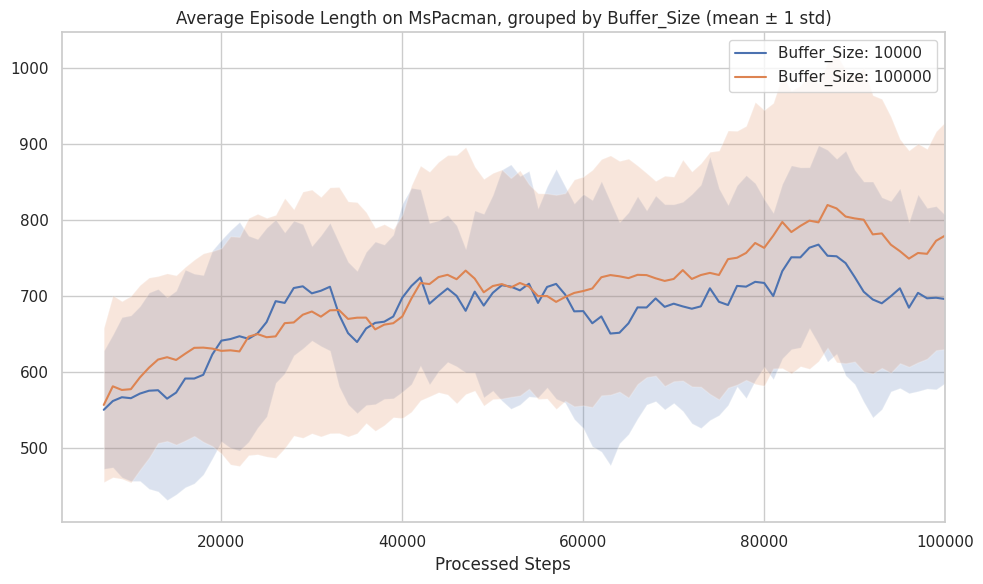

Plotting for metric: Time/sps_env_interaction
Buffer_Size
10000      3
100000    11
Name: Run_ID, dtype: int64


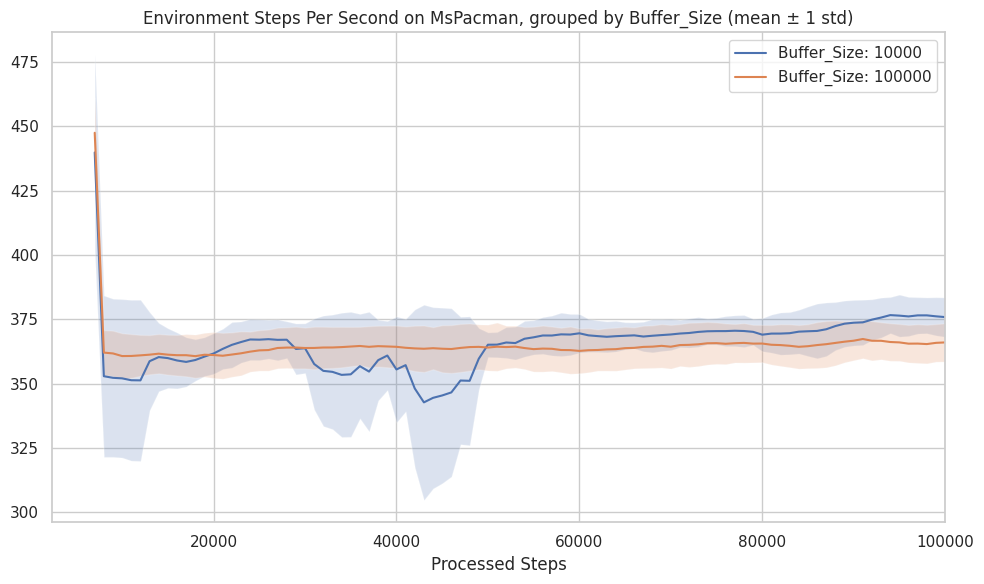

Plotting for metric: Loss/world_model_loss
Buffer_Size
10000      3
100000    11
Name: Run_ID, dtype: int64


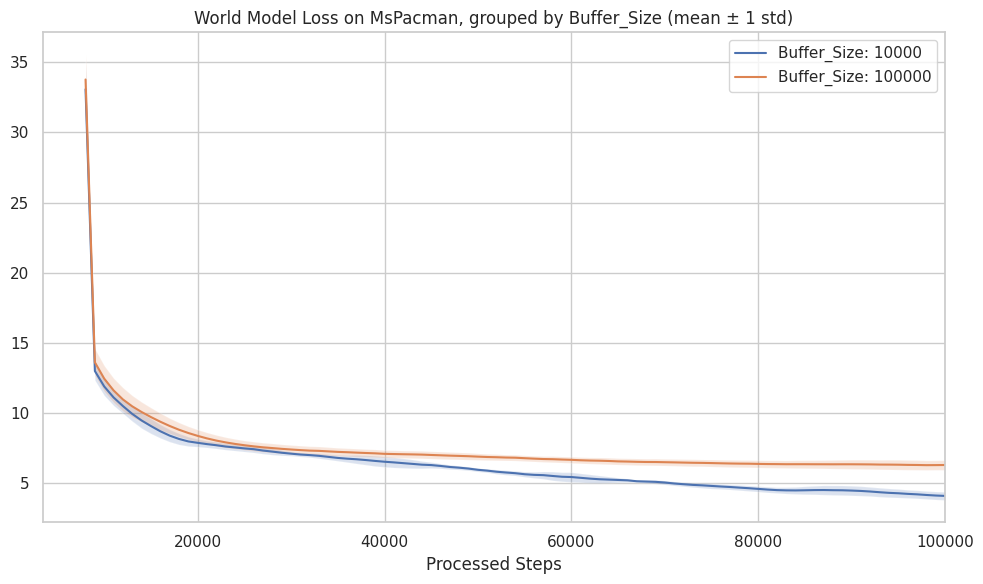

Plotting for metric: Loss/value_loss
Buffer_Size
10000      3
100000    11
Name: Run_ID, dtype: int64


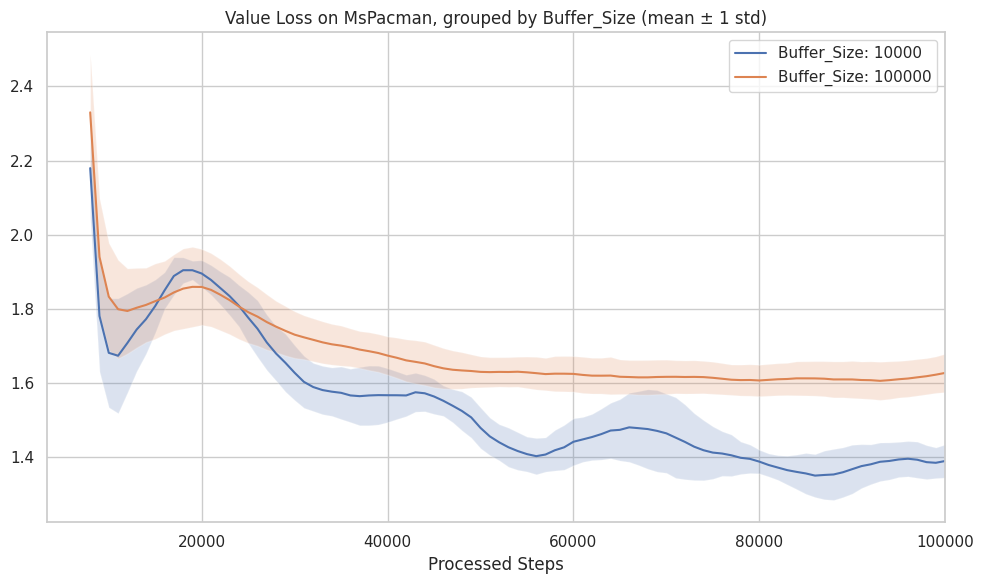

Plotting for metric: Loss/policy_loss
Buffer_Size
10000      3
100000    11
Name: Run_ID, dtype: int64


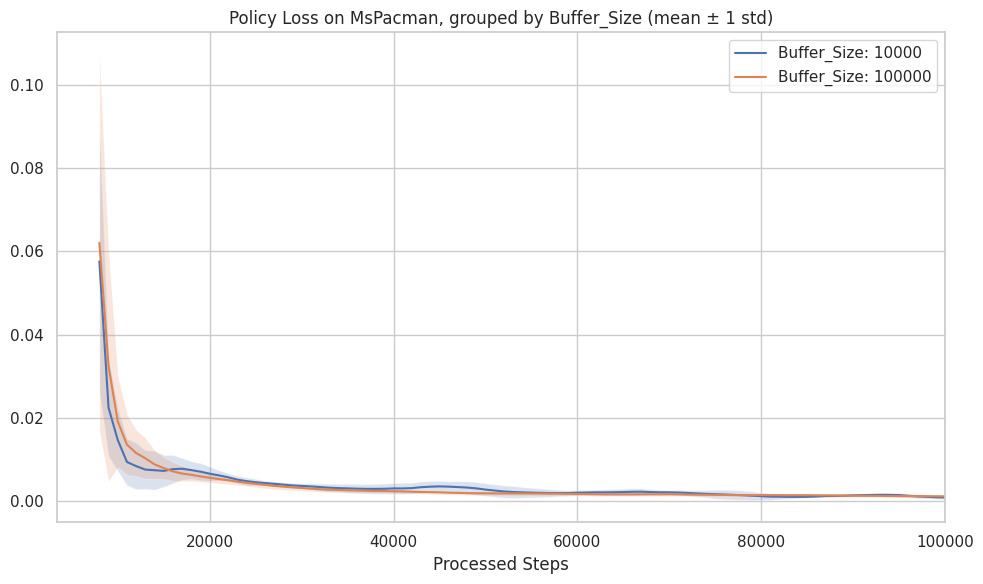

Plotting for metric: Loss/observation_loss
Buffer_Size
10000      3
100000    11
Name: Run_ID, dtype: int64


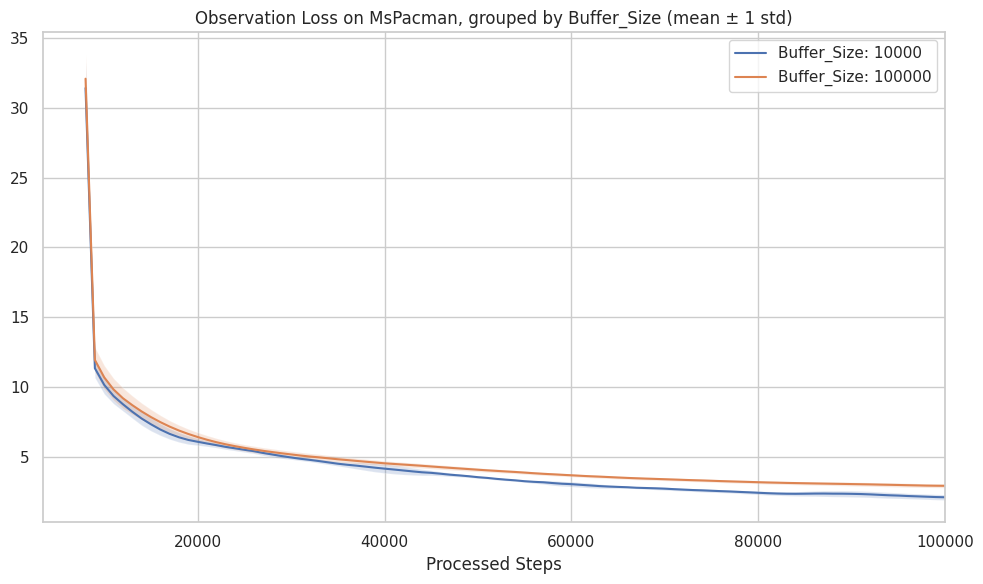

Plotting for metric: Loss/reward_loss
Buffer_Size
10000      3
100000    11
Name: Run_ID, dtype: int64


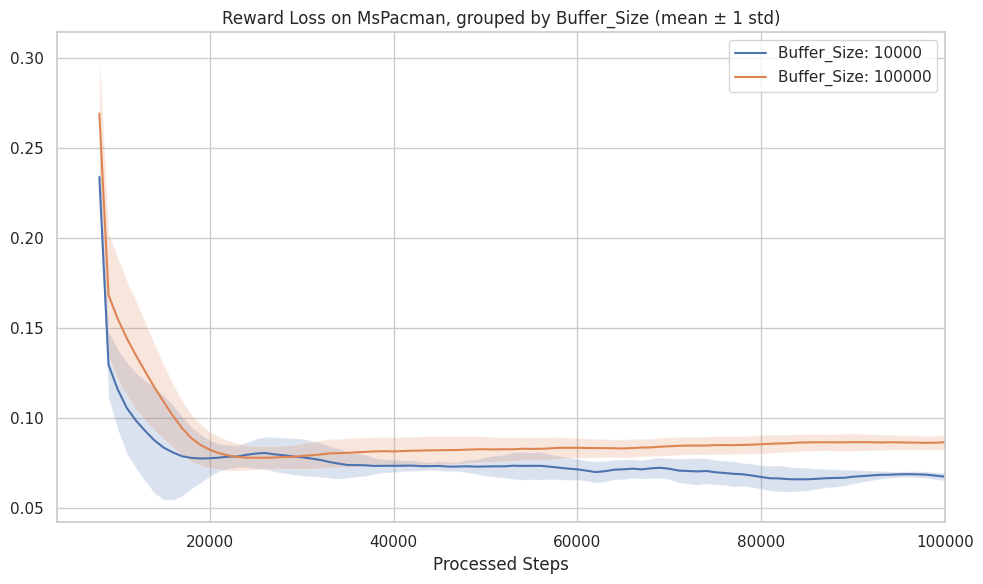

Plotting for metric: Loss/state_loss
Buffer_Size
10000      3
100000    11
Name: Run_ID, dtype: int64


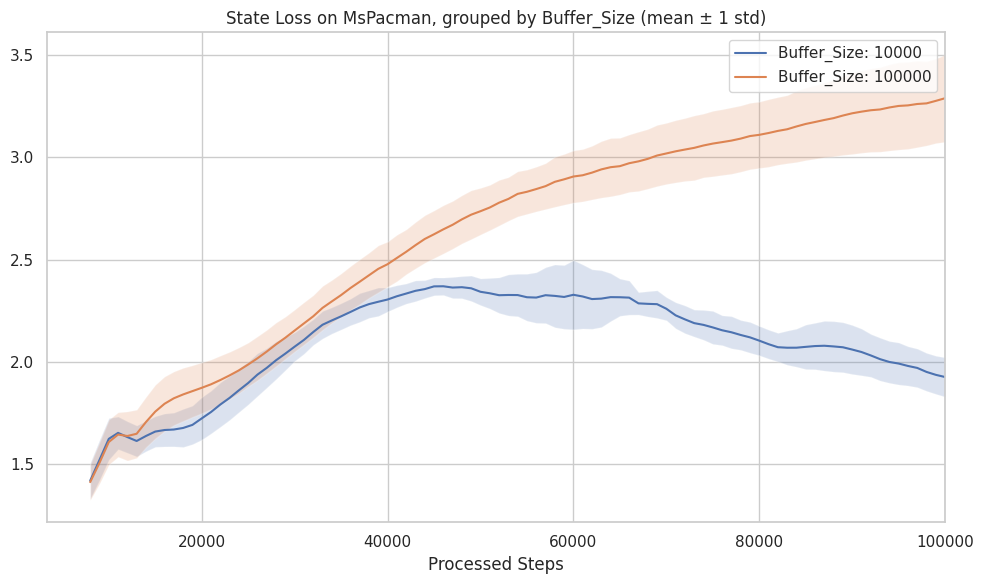

Plotting for metric: Loss/continue_loss
Buffer_Size
10000      3
100000    11
Name: Run_ID, dtype: int64


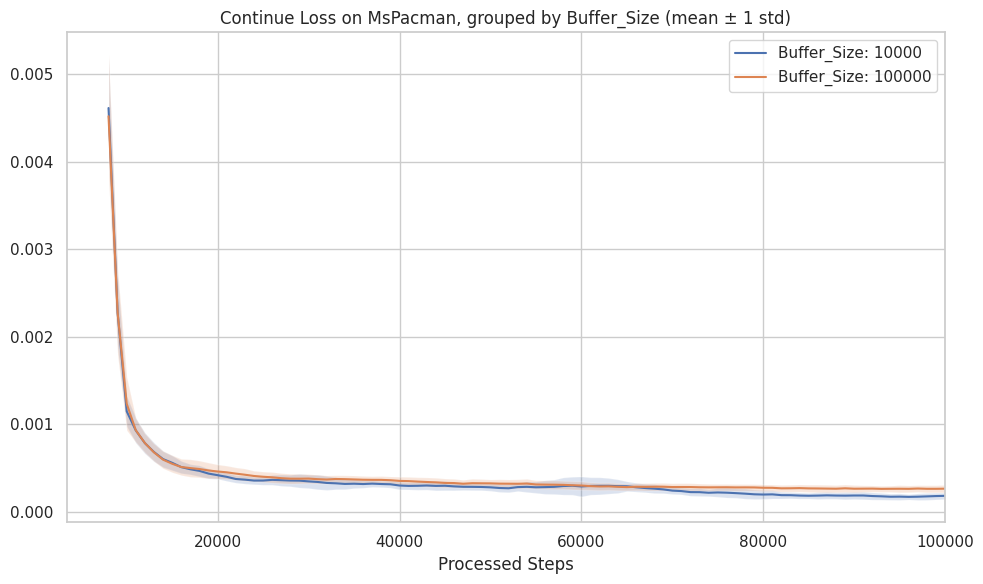

Plotting for metric: State/kl
Buffer_Size
10000      3
100000    11
Name: Run_ID, dtype: int64


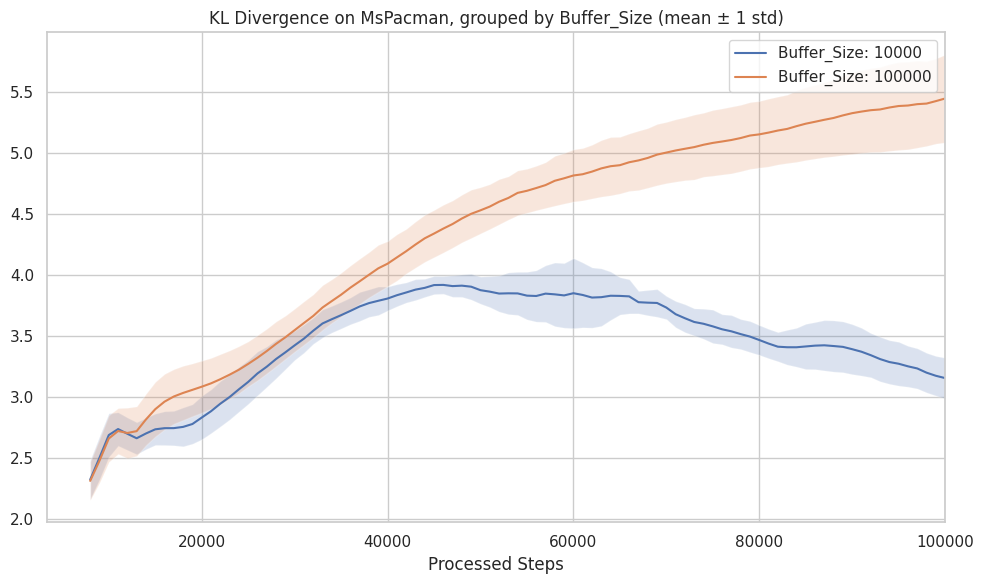

Plotting for metric: State/post_entropy
Buffer_Size
10000      3
100000    11
Name: Run_ID, dtype: int64


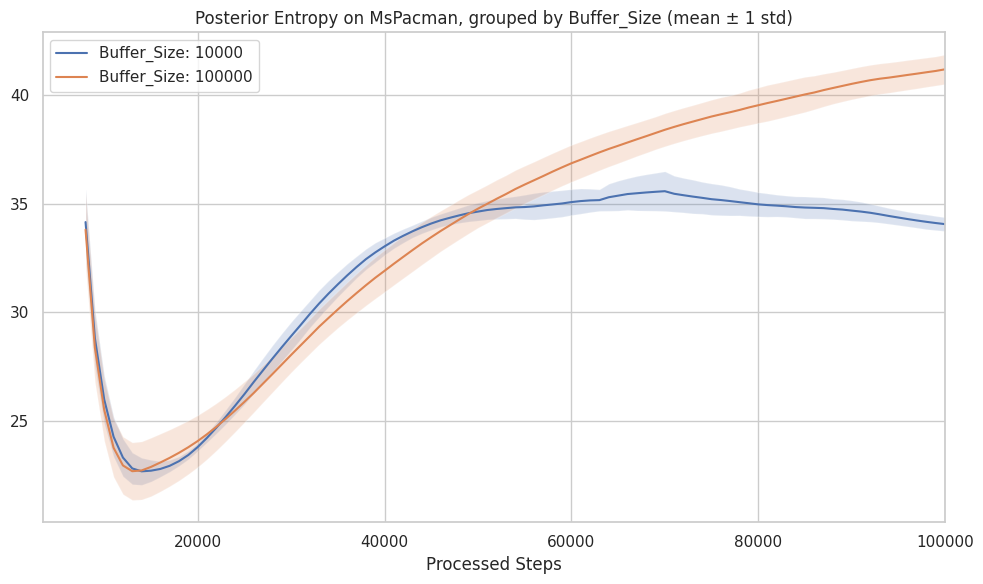

Plotting for metric: State/prior_entropy
Buffer_Size
10000      3
100000    11
Name: Run_ID, dtype: int64


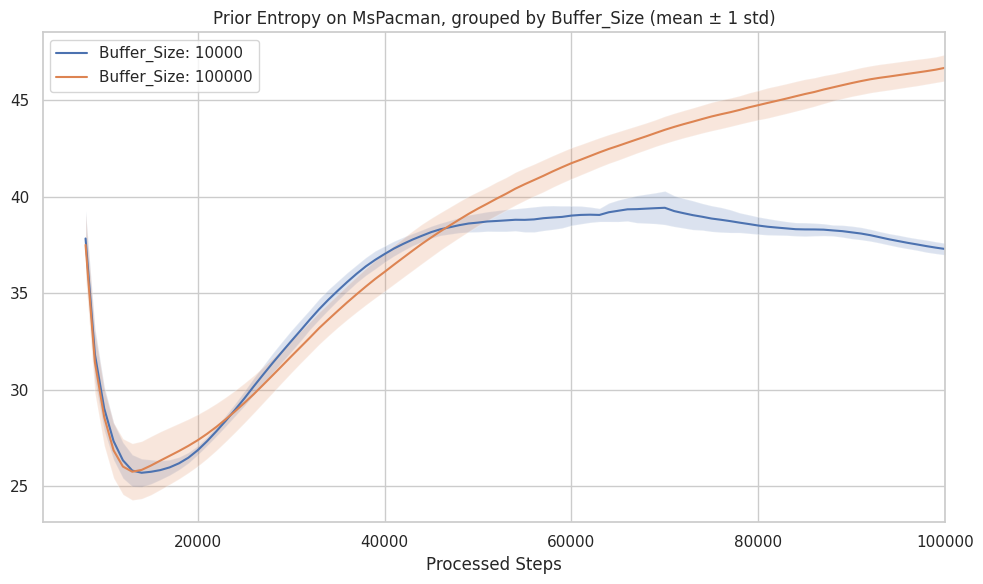

Plotting for metric: Grads/world_model
Buffer_Size
10000      3
100000    11
Name: Run_ID, dtype: int64


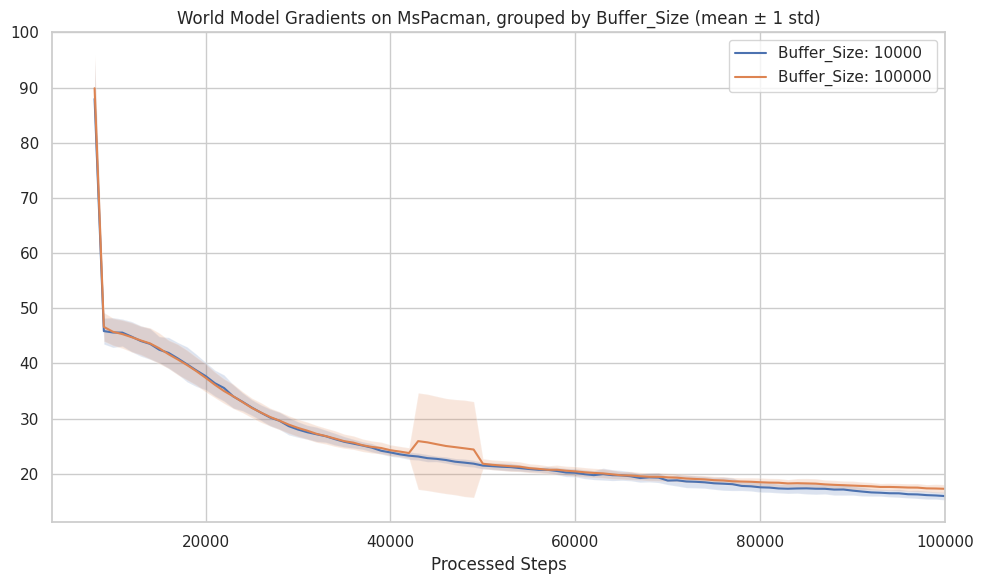

Plotting for metric: Grads/actor
Buffer_Size
10000      3
100000    11
Name: Run_ID, dtype: int64


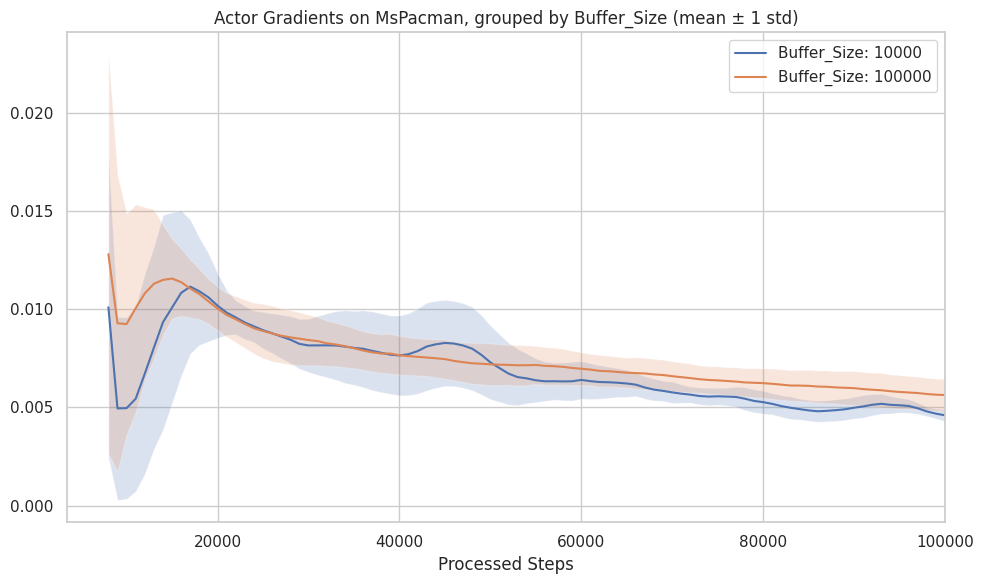

Plotting for metric: Grads/critic
Buffer_Size
10000      3
100000    11
Name: Run_ID, dtype: int64


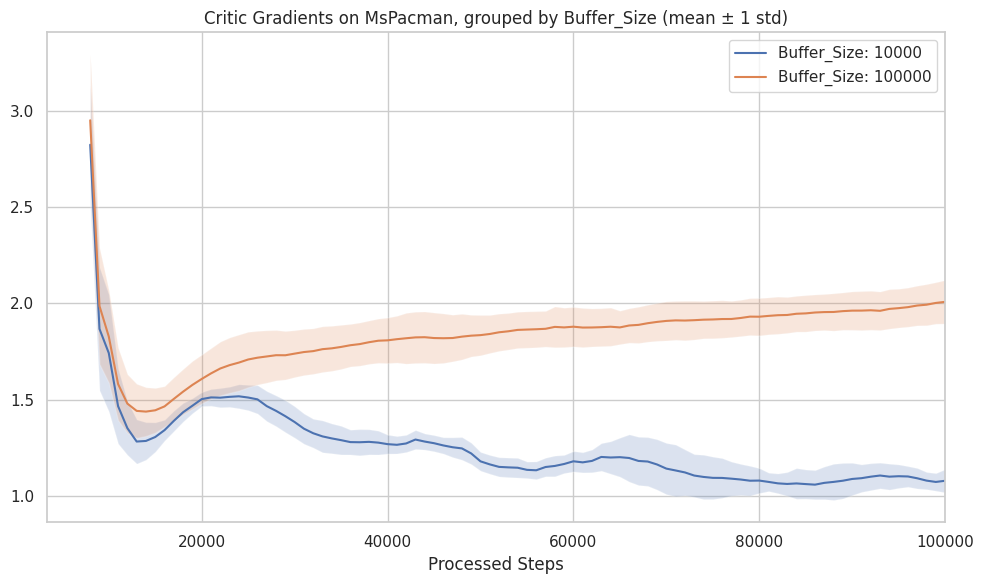

Plotting for metric: Loss/observation_loss_rgb
Buffer_Size
10000      3
100000    11
Name: Run_ID, dtype: int64


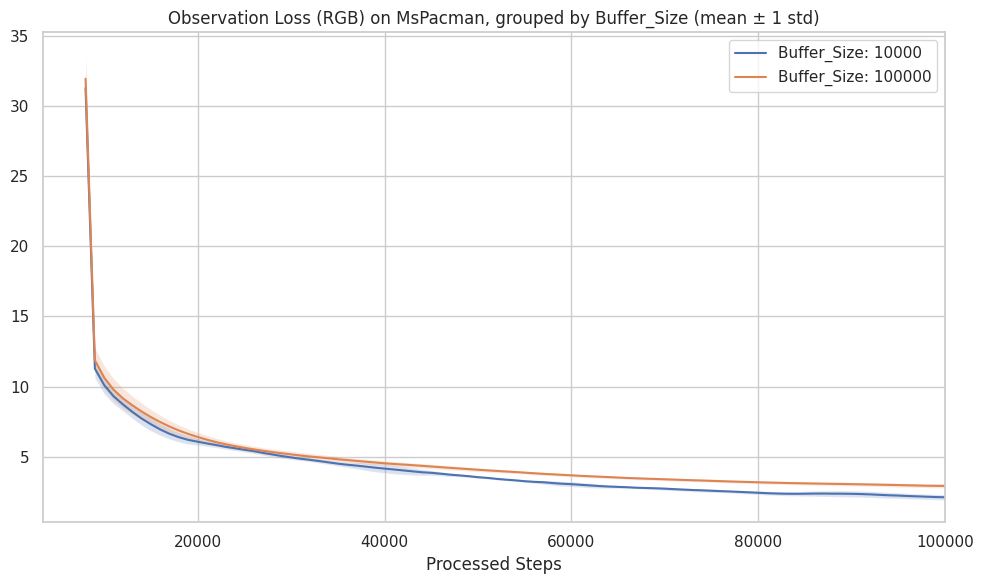

Plotting for metric: Loss/observation_loss_objects_position
Buffer_Size
10000      3
100000    11
Name: Run_ID, dtype: int64


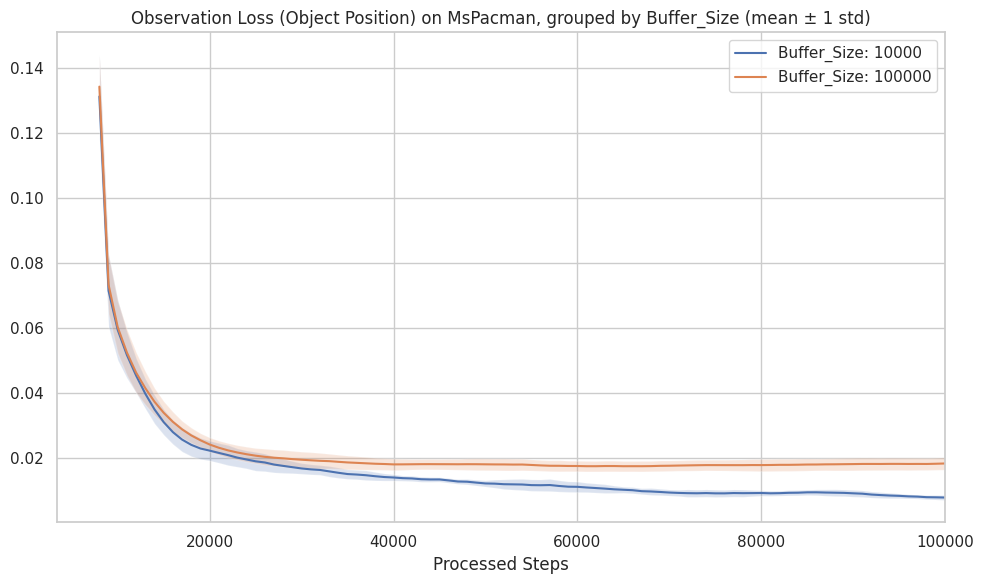

Plotting for metric: Time/sps_train
Buffer_Size
10000      3
100000    11
Name: Run_ID, dtype: int64


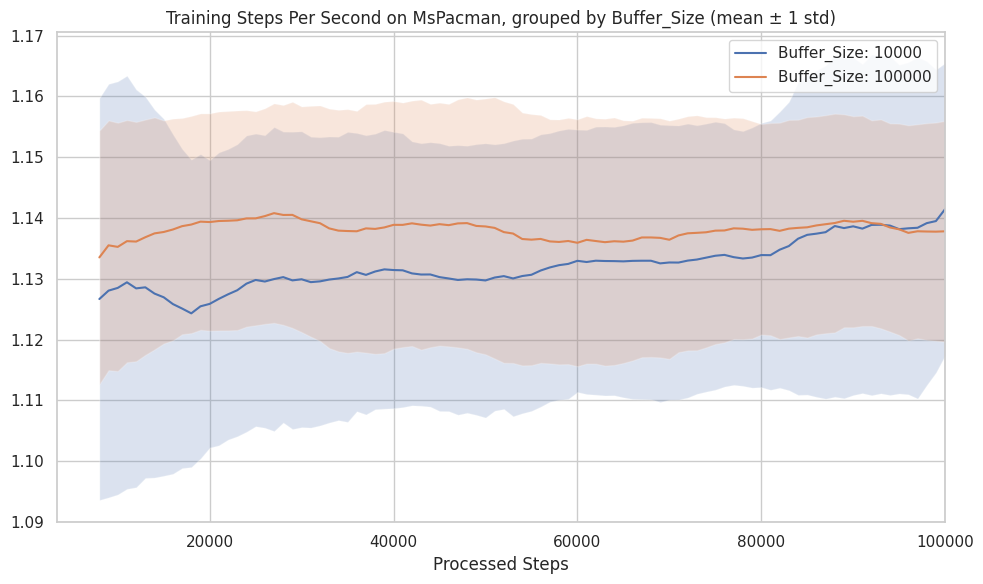

Plotting for metric: Test/cumulative_reward
Buffer_Size
10000      60
100000    220
Name: Value, dtype: int64


/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


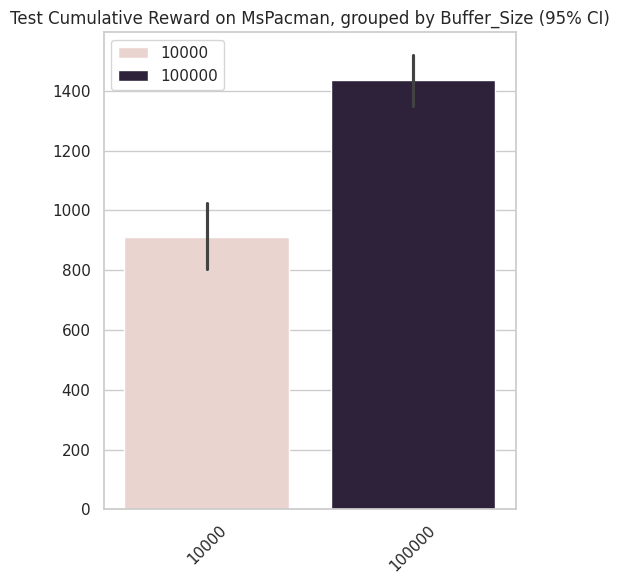

Plotting for metric: Train/cumulative_reward
Buffer_Size
100000    3
Name: Run_ID, dtype: int64


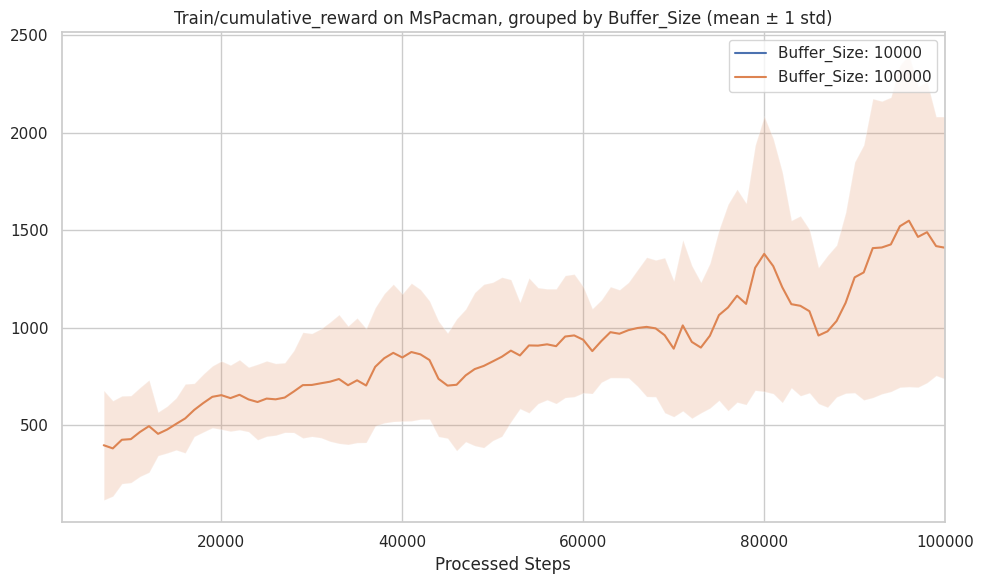

In [10]:
analyze_and_plot_by_parameter('MsPacman', 'Buffer_Size')

# Time

In [11]:
df = process_all_experiments('logs/runs/dreamer_v3/AssaultNoFrameskip-v4')

Total number of experiments processed: 48


AE_Keys
A1           5
A2           5
A3           4
DV3          5
O-Dreamer    5
Name: Run_ID, dtype: int64
Time/sps_env_interaction Barplot
2400
AE_Keys
A1           500
A2           500
A3           400
DV3          500
O-Dreamer    500
Name: Value, dtype: int64


/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

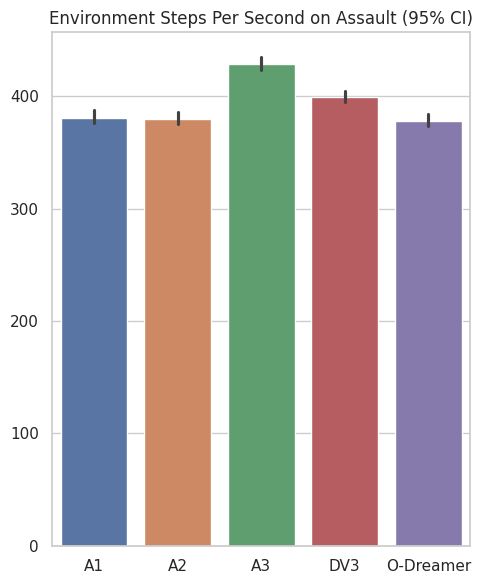

AE_Keys
A1           5
A2           5
A3           4
DV3          5
O-Dreamer    5
Name: Run_ID, dtype: int64
Time/sps_train Barplot
2376
AE_Keys
A1           495
A2           495
A3           396
DV3          495
O-Dreamer    495
Name: Value, dtype: int64


/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

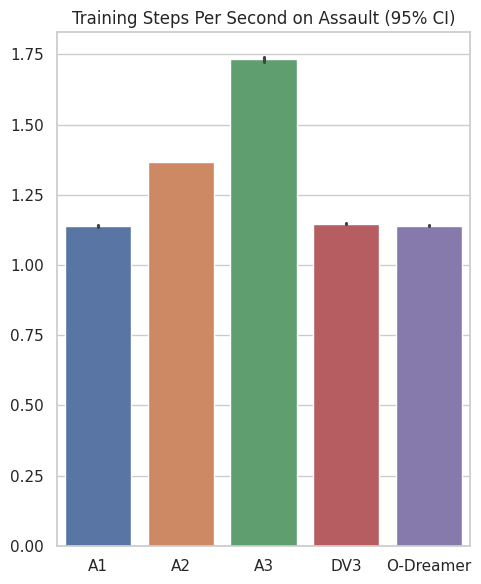

In [12]:

def barplot_given_metric(df: pd.DataFrame, env_id: str, metric:str, train_every: int = 2):
    sns.set_theme(style="whitegrid")
    filtered_df = df[(df['Metric']==metric) & (df['Train_Every'] == train_every) & (df['Buffer_Size'] == 100000) & (df['Obs_Loss_Regularizer'] == 1) & (df['Perturbation'] == 'None')]
    print(filtered_df.groupby('AE_Keys')['Run_ID'].nunique())
    filtered_df = filtered_df.drop(columns=['Run_ID', 'Metric', 'Train_Every', 'Seed', 'Step', 'Perturbation'])
    sns.set_style("whitegrid")
    sns.set_palette(PALETTE)
    # print number of entries for each AE_Keys
    print(f"{metric} Barplot")
    print(len(filtered_df))
    # TODO eval test scores don't seem to be present in the df
    print(filtered_df.groupby('AE_Keys')['Value'].count())


    # Create a bar plot showing the mean score grouped by MLP_Keys
    # Seaborn automatically calculates the confidence interval
    # and adds it as error bars
    plt.figure(figsize=(5, 6))
    sns.barplot(x="AE_Keys", y="Value", data=filtered_df.sort_values('AE_Keys'), errorbar="ci", hue="AE_Keys")
    # 
    plt.title(f'{get_metric_name(metric)} on {env_id.replace("NoFrameskip-v4", "")} (95% CI)')
    plt.xlabel('')
    plt.ylabel('')
    # position y-label on the top left of the plot
    plt.gca().yaxis.set_label_coords(-0.1, 0.5)

    plt.tight_layout()  # Adjust layout to make room for the rotated x-labels
    #plt.savefig(f'viz/{env_id}/{train_every}_{metric.replace("/", "_")}.png')
    plt.show()

barplot_given_metric(df, 'AssaultNoFrameskip-v4', 'Time/sps_env_interaction', 2)
barplot_given_metric(df, 'AssaultNoFrameskip-v4', 'Time/sps_train', 2)